In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

"""
data_root_folder='../data'
data_images_root_folder='../data/images'
"""
# replaced by kaggle paths
data_root_folder = "/kaggle/input/rakuten-france-multimodal-product-classification"
data_images_root_folder = "/kaggle/input/rakuten-france-multimodal-product-classification/images/images"

#/kaggle/input/rakuten-france-multimodal-product-classification/images
#/kaggle/input/rakuten-france-multimodal-product-classification/images/images/image_train

# Data exploration & preprocessing

In [3]:

X_train=pd.read_csv(f'{data_root_folder}/X_train_update.csv', index_col=0)
#X_test=pd.read_csv(f'{data_root_folder}/X_test_update.csv', index_col=0)
Y_train=pd.read_csv(f'{data_root_folder}/Y_train_CVw08PX.csv', index_col=0)
data=pd.concat([X_train,Y_train], axis=1 )
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
 4   prdtypecode  84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.9+ MB


* Columns types are relevant
* Data size is relevant for Machine Learning
* For the suggested X_test, Y_test is missing, the test data will be generated from the train data 

## Missing & duplicated

35% of 'description' column values are missing & 60% of 'description' are distinct

### Missing images ?

In [ ]:
notfound=False
for index, row in data.iterrows():
    imgid = row['imageid']
    prdid = row['productid']
    try:
        mpimg.imread(f'{data_images_root_folder}/image_train/image_{imgid}_product_{prdid}.jpg')
    except FileNotFoundError as error:  
       notfound=True
       print('Image not found', error)
if not notfound:
    print('No image is missing')
    

### Duplicated values

In [4]:
data_descnotna=data[-data.description.isna()]
data_desc_dup=data_descnotna[data_descnotna.duplicated(['description'])].groupby('description').agg(count=('prdtypecode', 'size'),prdtypecodes=('prdtypecode',lambda x: str(x.unique()))).sort_values(by=['count'], ascending=False).query('count>30')
display(data_desc_dup)

,count,prdtypecodes
description,,
<br>Attention !!! Ce produit est un import si les informations 'langues' et 'sous-titres' n'apparaissent pas sur cette fiche produit c'est que l'éditeur ne nous les a pas fournies. Néanmoins dans la grande majorité de ces cas il n'existe ni langue ni sous titres en français sur ces imports.,251,[40]
Taille: En format A5 (144 cm x 21 cm) Caractéistique: -Excellente durabilité avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualitévous pouvez y érire facilement,231,[2522]
Taille: En format A5 (144 cm x 21 cm) Caracteristique: -Excellente durabilite avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualite: ecrire facilement sur et assez epaisse.,188,[2522]
Taille: En format A5 (144 cm x 21 cm) Caract?istique: -Excellente durabilit?avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualit? ?rire facilement sur et assez ?aisse.,161,[2522]
Taille: En format A5 (144 cm x 21 cm) Caractéristique: -Excellente durabilit?avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualit? écrire facilement sur et assez épaisse.,88,[2522]
<br />,80,[1940 2522 1301]
Piscine hors-sol en acier ronde Fidji de la marque Gré Indispensable pour passer des vacances entre amis dans la fraîcheur de l&#39;eau cette piscine en acier ronde Fidji vous offre un espace de nage et de jeux d&#39;eau pour tous les goûts. Conçue avec une structure en tôle laminée à froid et traitée par galvanisation la piscine hors-sol Gré vous assure une forte résistance dans le temps. Pour la baignade et le confort elle est habillée d&#39;un liner d&#39;une épaisseur de 30/100 traité anti-UV pour prévenir son vieillissement prématuré. La piscine hors-sol acier ronde Fidji est équipée d&#39;un système de filtration à sable (inclus) complet et d&#39;un skimmer pour vous garantir une eau claire et propre tout au long de la saison de baignade. Pour accéder facilement et en toute sécurité au bassin elle est livrée avec une échelle 2 x 3 marches. L&#39;équipement de la piscine en acier ronde Fidji : - Structure en acier avec margelles et poteaux verticaux - Système de filtration 3 m³/h vannes 5 voies cuve de Ø 30 cm 23 kg de sables (silex) puissance 125 W. - Liner en PVC bleu 30/100 - Skimmer - Échelle de sécurité 2 x 3 marches Les caractéristiques selon le modèle de piscine : Piscine ronde Fidji Ø 370 cm - Dimensions extérieures (Ø x h) : 370 x 122 cm - Dimensions intérieures (Ø x h) : Ø 350 x 120 cm - Volume d&#39;eau : 1010 m3 - Espace nécessaire (L x l) : 400 x 400 cm Piscine ronde Fidji Ø 480 cm - Dimensions extérieures (Ø x h) : Ø 480 x 122 cm - Dimensions intérieures (Ø x h) : Ø 460 x 120 cm - Volume d&#39;eau : 1745 m3 - Espace nécessaire (L x l) : 500 x 500 cm Piscine ronde Fidji Ø 570 cm - Dimensions extérieures (Ø x h) : Ø 570 x 122 cm - Dimensions intérieures (Ø x h) : Ø 550 X 120 cm - Volume d&#39;eau : 2494 m3 - Espace nécessaire (L x l) : 600 x 600 cm,56,[2583]
Kit de piscine hors-sol ronde en acier Bora Bora de la marque Gré Installez une piscine hors-sol dans le jardin et faites vous plaisir avec la fraîcheur de l&#39;eau pour des moments de détente avec vos proches. Ce kit de piscine est complet et vous permettra de profiter au plus vite de votre installation. La piscine hors-sol Bora Bora est vendue avec un équipement qui comprend :- une structure en acier galvanisé 45/100 avec margelles et poteaux- un liner 30/100 de couleur bleue en PVC- un épurateur à cartouche 38 m³/h puissance de 70 W- un skimmer de couleur blanche- et une échelle 2 x 3 marches. Le montage de la piscine hors-sol ronde en acier Bora Bora Gré est estimé à 2 h pour 2/3 personnes.Les différentes dimensions disponibles pour la piscine hors-sol Bora Bora :La piscine Bora Bora Ø 320 m- Dimensions extérieures (Ø x h) : 320 x 122 cm- Dimensions intérieures (Ø x h) : 300 x 120 cm- Volume d&#39;

- Most of duplicated values are related to one type, which sets a corrolation between that could be useful in predicting the label
- The duplicated value '\<br />' can be deleted as it doesn't bring any semantic
- The duplicated value '...Attention !!! Ce produit est un import si les informations 'langues' et 'sous-titres'...' can be deleted as well.

## Product types exploration

### Distribution

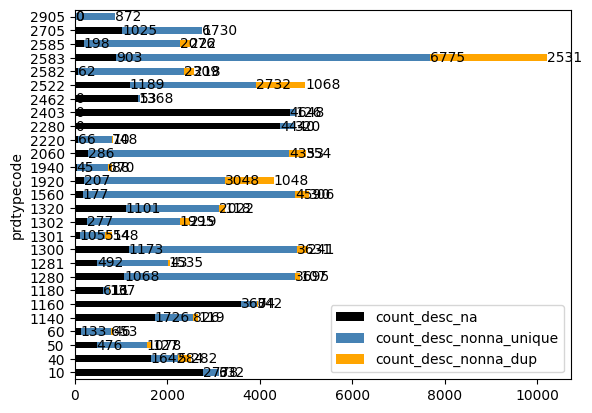

In [5]:
data_byprdtype_na=data.groupby('prdtypecode', group_keys=True).agg(count_desc_na=('description',lambda x: x.isna().sum()), count_desc_nonna_unique=('description',lambda x: (x[x.notna()].unique()).size), count_desc_nonna_dup=('description',lambda x: x[x.notna()].duplicated().sum()))
ax1=data_byprdtype_na.plot.barh(stacked=True, color=['black', 'steelblue', 'orange'])
ax1.bar_label(ax1.containers[0], labels=data_byprdtype_na['count_desc_na'])
ax1.bar_label(ax1.containers[1], labels=data_byprdtype_na['count_desc_nonna_unique'])
ax1.bar_label(ax1.containers[2], labels=data_byprdtype_na['count_desc_nonna_dup'])
plt.show();

- Product types are not evenly distributed, 2583 is an outlier 
- Need to rebalance the data, by : 
    * For types with highest counts, deleting rows with description = NA values & replacing duplicates
    * Some product types have small amount of relevant 'description', for those a strategy might be relying on the 'designation'
    * Then rebalance the rest following guidelines [here](https://medium.com/@dlikhitha99/all-methods-for-balancing-imbalanced-data-decfe1f4048d)




### Guess what's behind the product type code ?

The goal of following routine is to : 

* Identifiy to what extent the 'designation' & 'description' content are capable to relate to a product type
* What kind of data cleaning should be carried out to make text data the most relevant
* Determine the semantic behind the product type code by displaying random pictues and top keywords for each product type code, it would help in better human interpretation of results during the model experimentation.


In [21]:
from bs4 import BeautifulSoup

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


First 1000 entries for type 10


,designation,description,prdtypecode
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,10
6,Christof E: Bildungsprozessen Auf Der Spur,NaN,10
46,Vassivière -En-Limousin. Le Jardin Art Et Lie...,NaN,10
131,Dr. Mercurius' Heilsame Reise Zum Planeten Erde,NaN,10
188,La Promenade Au Parc,NaN,10
...,...,...,...
28085,Riesgo Y Prevención De La Anorexia Y La Bulimia,NaN,10
28093,50 Ways To Get A Job,A new personalized way to find the perfect job...,10
28136,Mixtures Compounds & Solutions (Material Matters),NaN,10
28138,Michael Busselle's Guide To Travel And Vacatio...,NaN,10


Before cleaning
Top 50 features when designation ['10' '100' '11' 'american' 'ans' 'art' 'book' 'books' 'cd' 'collection'
 'cours' 'droit' 'edition' 'education' 'europe' 'français' 'grand' 'great'
 'guerre' 'guide' 'histoire' 'history' 'homme' 'jean' 'journal' 'lettres'
 'life' 'livre' 'maison' 'monde' 'new' 'oeuvres' 'pages' 'paris' 'pays'
 'pierre' 'pratique' 'revue' 'saint' 'science' 'secrets' 'siècle' 'temps'
 'tome' 'vie' 'vol' 'volume' 'voyage' 'world' 'édition']
Top 50 features when description ['039' '15' '39' 'ammareal' 'ancien' 'anglais' 'année' 'associations'
 'auteur' 'bibliothèque' 'bibliothèques' 'bon' 'book' 'caritatives'
 'collection' 'commentaire' 'couverture' 'donnons' 'editeur' 'edition'
 'etat' 'fournis' 'frais' 'histoire' 'isbn' 'jean' 'ligne' 'livre'
 'livres' 'marcel' 'net' 'occasion' 'organisations' 'pages' 'partenaires'
 'prix' 'recyclons' 'reverse' 'reversons' 'sommaire' 'titre' 'tome'
 'traces' 'traduit' 'tranche' 'usure' 'vendons' 'vie' 'édition' 'état']
Top

['vol',
 'revue',
 'pays',
 'books',
 'petit',
 'grand',
 'français',
 'cours',
 'droit',
 'education',
 'voyage',
 'oeuvres',
 'philosophie',
 'american',
 'history',
 'volumes',
 'guerre',
 'pratique',
 'ans',
 'life',
 'paris',
 'new',
 'secrets',
 'ii',
 'world',
 'great',
 'volume',
 'temps',
 'journal',
 'pierre',
 'cd',
 'lettres',
 'monde',
 'siècle',
 'art',
 'homme',
 'europe',
 'science']

words found in 'description' NOT in 'designation': 38


['salissures',
 'usure',
 'editeur',
 'vendons',
 'livres',
 'année',
 'tranche',
 'etat',
 'anglais',
 'net',
 'auteur',
 'reverse',
 'ligne',
 'recyclons',
 'sommaire',
 'état',
 'organisations',
 'prix',
 'occasion',
 'bibliothèque',
 'fournis',
 'bibliothèques',
 'titre',
 'traduit',
 'ancien',
 'marcel',
 'associations',
 'reversons',
 'ammareal',
 'bon',
 'frais',
 'caritatives',
 'commentaire',
 'donnons',
 'traces',
 'partenaires',
 'couverture',
 'isbn']

words found in both 'description' AND 'designation': 12


['histoire',
 'vie',
 'collection',
 'tome',
 'édition',
 'livre',
 'pages',
 'saint',
 'jean',
 'edition',
 'guide',
 'book']

First 1000 entries for type 40


,designation,description,prdtypecode
31,X-Men 3 - The Movie,NaN,40
34,The Lord Or Thé Rings,NaN,40
47,Shin Masoukishin Panzer Warfare (Import Jap),NaN,40
50,Jeu Pc Cd-Rom : Azteca,NaN,40
101,Innercity Burnout [Import Allemand] [Jeu Pc],<br>Attention !!! Ce produit est un import si...,40
...,...,...,...
33552,Capcom Generation 1 - Saturn - Jap,NaN,40
33575,Cricket 2004 (Ps2) [Import Anglais] [Jeu Ps2],<br>Attention !!! Ce produit est un import si...,40
33655,Battlefield 1942 Anthologie - Ea Value Games,NaN,40
33662,2 Paires Jeu De Simulation - Echelle 1:6 Baske...,<p><b>La description:</b></p><br /><p> 1/6 cha...,40


Before cleaning
Top 50 features when designation ['360' 'adaptateur' 'allemand' 'anglais' 'audio' 'best' 'cd' 'collection'
 'collector' 'commutateur' 'complet' 'console' 'contrôleur' 'câble' 'dark'
 'dragon' 'ds' 'edition' 'ensemble' 'game' 'hits' 'housse' 'ii' 'jap'
 'japon' 'jeu' 'jeux' 'kit' 'magideal' 'manette' 'nintendo' 'pack' 'pc'
 'playstation' 'pro' 'protection' 'ps3' 'ps4' 'remplacement' 'simulator'
 'sony' 'super' 'switch' 'uk' 'version' 'vidéo' 'wars' 'wii' 'world'
 'xbox']
Top 50 features when description ['1x' '39' '43' 'apparaissent' 'attention' 'audio' 'bouton' 'boutons'
 'charge' 'commutateur' 'compatible' 'console' 'contrôleur' 'câble'
 'eacute' 'existe' 'facile' 'fiche' 'forfait' 'fournies' 'français'
 'grande' 'haute' 'imports' 'informations' 'jeu' 'jeux' 'langue' 'langues'
 'majorité' 'matériel' 'nintendo' 'pièce' 'pièces' 'plastique' 'pouces'
 'prise' 'produit' 'protection' 'ps4' 'qualité' 'raison' 'remarque'
 'silicone' 'spécification' 'titres' 'type' 'usb' 'xbox

['simulator',
 'complet',
 'housse',
 'uk',
 'jap',
 'version',
 'wars',
 'star',
 'best',
 'japon',
 'magideal',
 'switch',
 'yxjjpj',
 'pro',
 'collector',
 'anglais',
 'ensemble',
 'remplacement',
 'vidéo',
 'game',
 'manette',
 'wii',
 'ii',
 'dragon',
 'world',
 'ds',
 'edition',
 'collection',
 'cd',
 'dvd',
 'adaptateur',
 'hits',
 'dark',
 'pack',
 'super',
 'playstation',
 'kit']

words found in 'description' NOT in 'designation': 37


['produit',
 'écran',
 'charge',
 'haut',
 'longueur',
 'utiliser',
 'inch',
 'facile',
 'matériel',
 'forfait',
 'boutons',
 'fil',
 'support',
 'raison',
 'usb',
 'spécification',
 'qualité',
 'hdmi',
 'pièce',
 'haute',
 'poignée',
 'tournevis',
 'plastique',
 'pouces',
 'contre',
 'bouton',
 'eacute',
 'mesure',
 'type',
 'silicone',
 'matériau',
 'remarque',
 'installer',
 'jouer',
 'pièces',
 'prise',
 'compatible']

words found in both 'description' AND 'designation': 13


['commutateur',
 'jeux',
 'ps',
 'contrôleur',
 'protection',
 'console',
 'audio',
 'jeu',
 'sony',
 'câble',
 'nintendo',
 'pc',
 'xbox']

First 1000 entries for type 50


,designation,description,prdtypecode
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,50
80,Contrôleur De Jeu Mobile Tir Sensible Et But J...,Contrôleur de jeu mobile Tir sensible et But J...,50
163,Fauteuil De Bureau Gaming Swift Noir Et Rouge,NaN,50
165,Sony Dualshock 4 V2 - Gamepad - Sans Fil - Blu...,NaN,50
207,Manette Filaire Ps3 / Pc Shockpad Ghx5ef Shock...,Manette filaire compatible PS3 / PC ShockPad r...,50
...,...,...,...
50159,Pochette Etui Pochette Etui Silicone Pour Suor...,Pochette de protection en silicone pour la bo?...,50
50183,Plateforme Chariot Avec Lentille Kem 450aaa Ps...,<p>Plateforme + chariot avec<strong> lentille ...,50
50185,1 Paire Joy-Con Gamepad Poignée De Verrouillag...,1 paire Joy-Con Gamepad poignée de verrouillag...,50
50242,Mini Btv Keypad Sans Fil Pour Sony Ps4 Playsta...,Mini BTV3.0 clavier sans fil clavier pour Sony...,50


Before cleaning
Top 50 features when designation ['360' '3ds' 'accessoires' 'adaptateur' 'autocollants' 'bleu' 'bluetooth'
 'charge' 'chargeur' 'commutateur' 'console' 'controller' 'contrôleur'
 'coque' 'câble' 'ds' 'fil' 'filaire' 'game' 'gamepad' 'gaming' 'housse'
 'jeu' 'jeux' 'joy' 'joystick' 'manette' 'manettes' 'mini' 'nintendo'
 'notice' 'pc' 'playstation' 'portable' 'pro' 'protection' 'ps3' 'ps4'
 'remplacement' 'rouge' 'silicone' 'skylanders' 'slim' 'sony' 'super'
 'support' 'switch' 'usb' 'wii' 'xbox']
Top 50 features when description ['1x' '34' '39' '43' 'batterie' 'bluetooth' 'bouton' 'boutons'
 'caractéristiques' 'charge' 'chargeur' 'commutateur' 'compatible' 'con'
 'console' 'contre' 'controller' 'contrôleur' 'câble' 'emballage' 'facile'
 'fil' 'fonction' 'haute' 'inclus' 'jeu' 'jeux' 'jouer' 'joy' 'manette'
 'nintendo' 'paquet' 'poids' 'poignée' 'portable' 'poussière' 'produit'
 'protection' 'ps4' 'qualité' 'rayures' 'silicone' 'support' 'switch'
 'temps' 'type' 'usb' 'w

['station',
 'housse',
 'joystick',
 'autocollants',
 'manettes',
 'slim',
 'pro',
 'coque',
 'gamepad',
 'bleu',
 'remplacement',
 'rouge',
 'game',
 'filaire',
 'gaming',
 'mini',
 'notice',
 'ds',
 'skylanders',
 'lite',
 'adaptateur',
 'sony',
 'super',
 'accessoires',
 'playstation']

words found in 'description' NOT in 'designation': 25


['poids',
 'produit',
 'écran',
 'emballage',
 'facilement',
 'con',
 'facile',
 'rayures',
 'jouer',
 'boutons',
 'utilisation',
 'paquet',
 'fonction',
 'qualité',
 'haute',
 'poignée',
 'contre',
 'bouton',
 'temps',
 'inclus',
 'caractéristiques',
 'type',
 'poussière',
 'prise',
 'compatible']

words found in both 'description' AND 'designation': 25


['chargeur',
 'charge',
 'ps',
 'jeu',
 'câble',
 'switch',
 'protection',
 'fil',
 'support',
 'joy',
 'pc',
 'usb',
 'jeux',
 'manette',
 'contrôleur',
 'bluetooth',
 'wii',
 'batterie',
 'nintendo',
 'xbox',
 'commutateur',
 'controller',
 'console',
 'silicone',
 'portable']

First 1000 entries for type 60


,designation,description,prdtypecode
40,Mini Console De Jeux Double Joueurs 8 Bits Con...,Nom de la marque:NoEnName_Null<br />Affichage ...,60
180,Nouvelle Console De Jeu Vidéo Portable Rétro 1...,Affichage de couleur:Oui<br />Paquet:Oui<br />...,60
270,5.1 Pouces Hd Écran Double Joystick Lecteur De...,Numéro du modèle:model 310<br />Taille de l&#3...,60
299,Lecteur Nostalgique Mini Lecteurs De Jeux Vidé...,Affichage de couleur:Oui<br />Paquet:Oui<br />...,60
375,4.3 ''multi-Fonction Portable Jeu Console De J...,Affichage de couleur:Oui<br />Nom de la marque...,60
...,...,...,...
84403,Q9 3000 Jeux Rétro Console De Jeu Portable 60h...,Nom de la marque:POWKIDDY<br />Affichage de co...,60
84437,Game & Watch Manhole,Game & Watch Manhole New Wide Screen date sort...,60
84460,Microsoft Xbox One S 1tb + Playerunknowns Batt...,<b>Laissez-vous surprendre.</b><br /> Bienvenu...,60
84625,Rétro Portable Mini Console De Jeu Portable 32...,Nom de la marque:Rondaful,60


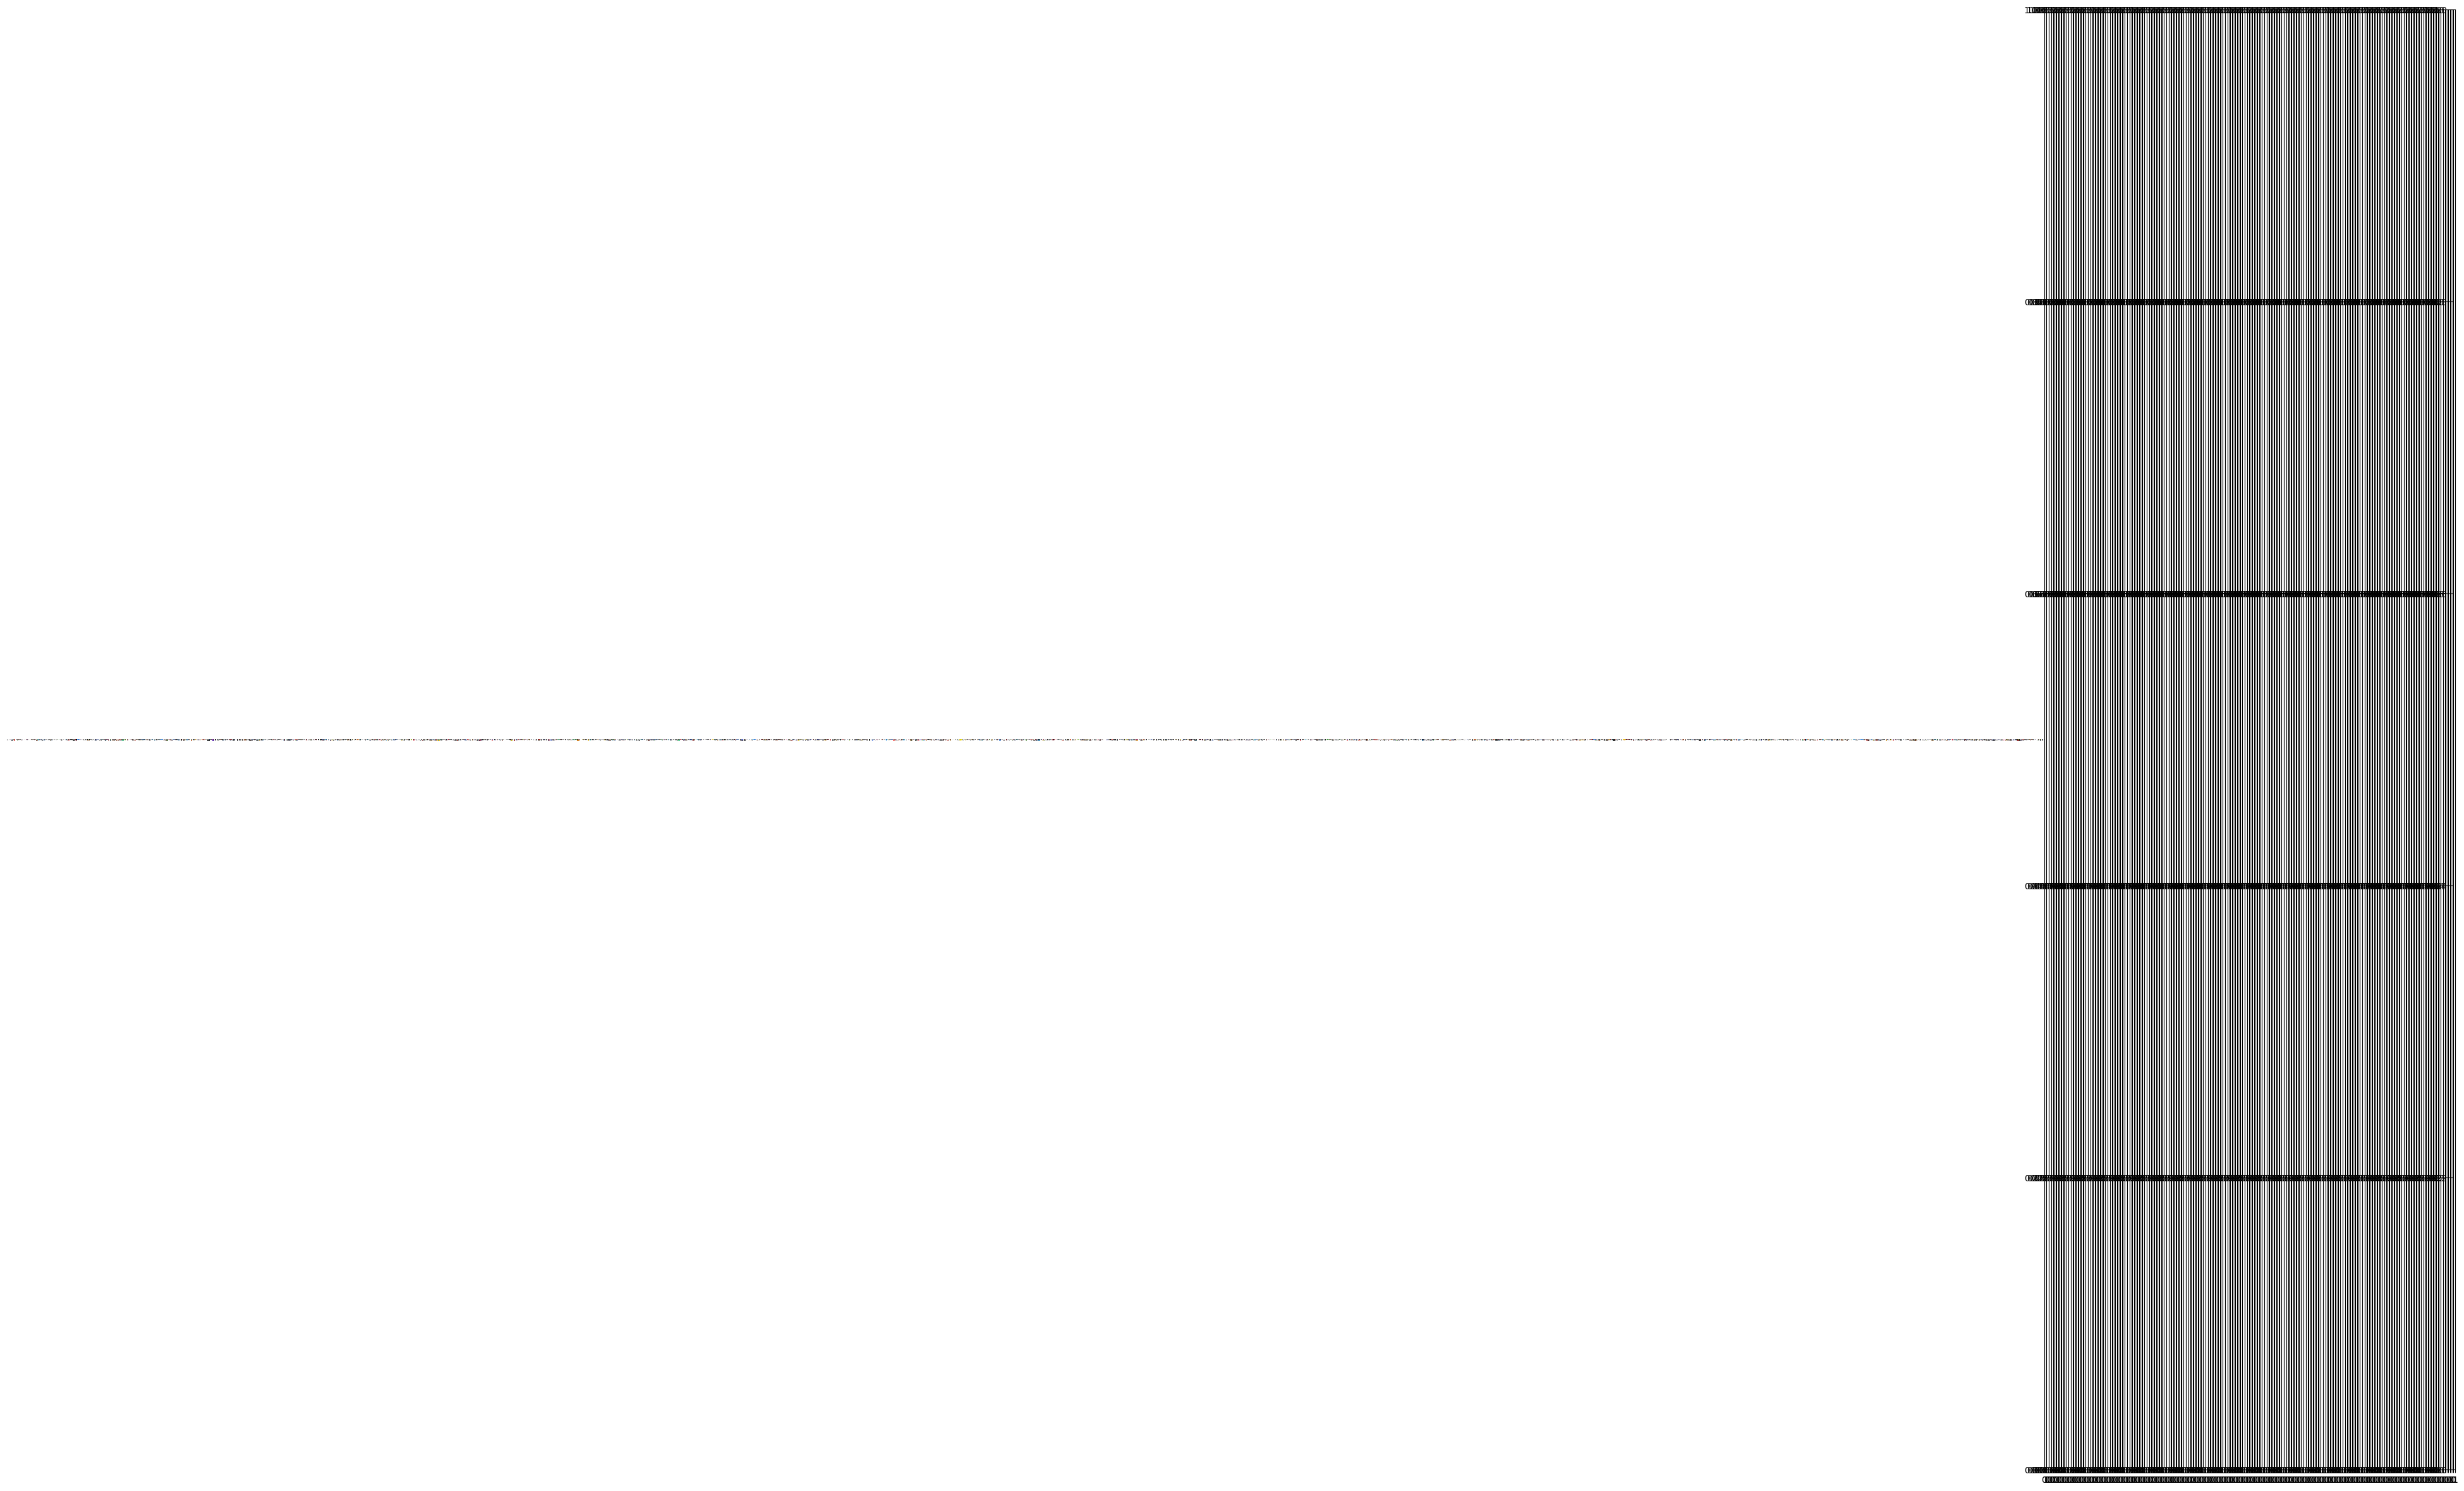

Before cleaning
Top 50 features when designation ['16' '3000' '500' '600' 'arcade' 'av' 'bit' 'bits' 'cadeau' 'caméra'
 'carte' 'charge' 'classique' 'classiques' 'console' 'consoles' 'coolbaby'
 'double' 'enfant' 'enfants' 'famille' 'fc' 'gba' 'hd' 'hdmi' 'intégré'
 'jeu' 'jeux' 'joueur' 'joueurs' 'lcd' 'lecteur' 'machine' 'manette'
 'mini' 'mp4' 'nes' 'nintendo' 'nostalgique' 'poche' 'portable' 'pouces'
 'rs' 'rétro' 'sortie' 'support' 'tv' 'vidéo' 'xbox' 'écran']
Top 50 features when description ['27' '30' '34' '39' '43' 'affichage' 'av' 'battery' 'built' 'classic'
 'color' 'communication' 'console' 'eacute' 'ecran' 'feature' 'function'
 'game' 'games' 'handheld' 'hdmi' 'inch' 'jeu' 'jeux' 'marque' 'mini'
 'modèle' 'nintendo' 'noenname_null' 'nom' 'numéro' 'output' 'package'
 'paquet' 'player' 'players' 'portable' 'retro' 'rs' 'screen' 'size'
 'support' 'tactile' 'tv' 'type' 'usb' 'video' 'xbox' 'yes' 'écran']
Top 50 features when designation+description ['30' '34' '39' '43' 'afficha

['av',
 'mémoire',
 'classique',
 'charge',
 'joueur',
 'fc',
 'gba',
 'ps',
 'bit',
 'rétro',
 'classiques',
 'double',
 'lecteur',
 'hd',
 'enfants',
 'famille',
 'vidéo',
 'poche',
 'hdmi',
 'intégré',
 'manette',
 'machine',
 'consoles',
 'enfant',
 'pouces',
 'mp',
 'coolbaby',
 'arcade',
 'joueurs',
 'bits',
 'lcd',
 'cadeau',
 'caméra',
 'nes',
 'sortie',
 'nostalgique',
 'prise',
 'carte']

words found in 'description' NOT in 'designation': 38


['consolepaquet',
 'ouicommunication',
 'usbtaille',
 'handheld',
 'ecran',
 'depaquet',
 'ouitaille',
 'modèle',
 'numéro',
 'ouipaquet',
 'denom',
 'games',
 'size',
 'noenname_nullcommunication',
 'ouiecran',
 'marque',
 'ouinuméro',
 'game',
 'usbpaquet',
 'detaille',
 'paquet',
 'usb',
 'communication',
 'player',
 'video',
 'built',
 'tactile',
 'nom',
 'noenname_nullaffichage',
 'classic',
 'eacute',
 'denuméro',
 'retro',
 'affichage',
 'type',
 'decommunication',
 'ouinom',
 'inch']

words found in both 'description' AND 'designation': 12


['jeux',
 'écran',
 'console',
 'mini',
 'jeu',
 'portable',
 'rs',
 'support',
 'ds',
 'nintendo',
 'tv',
 'xbox']

First 1000 entries for type 1140


,designation,description,prdtypecode
18,Power Rangers Rouge Force Mystic Figurine Tran...,NaN,1140
23,Véhicule Star Wars A-Ast5,véhicule vintage de la saga star wars le A-AST5,1140
66,Magnet Europe Paris 44,NaN,1140
72,Lampe Star Wars - Lampe Neon Sabre Laser,Lampe néon taille env. 22 x 28 cm avec base d¿...,1140
98,It - Bobble Head Pop N° 539 - Beverly With Key...,NaN,1140
...,...,...,...
31888,Sons Of Anarchy - T-Shirt Outlaw (M),T-shirt haute qualité sous licence officielle ...,1140
31938,Funko Pop Television Twin Peaks Leland Palmer ...,NaN,1140
31951,Robin Des Bois - Figurines De Collection,Figurine en résine figurine de collection,1140
31965,Mug Marvel Retro Serie 1 - Marvel Group,Mug Marvel Retro serie 1 - Marvel Group,1140


Before cleaning
Top 50 features when designation ['10' 'action' 'ball' 'batman' 'black' 'collection' 'comics' 'dc' 'disney'
 'dragon' 'exclusive' 'figure' 'figurine' 'figurines' 'funko' 'gundam'
 'happy' 'harry' 'japan' 'logo' 'lot' 'magnet' 'marvel' 'mcdo' 'meal'
 'metal' 'mini' 'mug' 'piece' 'plomb' 'pop' 'porte' 'potter' 'pvc' 'saint'
 'scale' 'series' 'set' 'shirt' 'star' 'statue' 'statuette' 'super'
 'série' 'toy' 'toys' 'ver' 'version' 'wars' 'xl']
Top 50 features when description ['10' '100' '10cm' '34' '39' 'accessoires' 'article' 'boite' 'box' 'boîte'
 'collection' 'coton' 'céramique' 'disney' 'décor' 'eacute' 'egrave'
 'emballage' 'env' 'fenêtre' 'figurine' 'figurines' 'funko' 'grande'
 'haute' 'imprimé' 'individuel' 'informations' 'licence' 'main' 'matière'
 'modèle' 'mug' 'métal' 'officielle' 'plastique' 'pop' 'porte' 'pvc'
 'qualité' 'shirt' 'socle' 'span' 'star' 'statuette' 'série' 'type'
 'vendu' 'vinyl' 'window']
Top 50 features when designation+description ['10' '100' 

['harry',
 'set',
 'series',
 'plomb',
 'toys',
 'saint',
 'potter',
 'happy',
 'version',
 'toy',
 'wars',
 'logo',
 'xl',
 'japan',
 'statue',
 'figure',
 'ver',
 'gundam',
 'metal',
 'action',
 'batman',
 'black',
 'magnet',
 'marvel',
 'dc',
 'seiya',
 'dragon',
 'meal',
 'piece',
 'lot',
 'exclusive',
 'scale',
 'super',
 'mcdo',
 'comics',
 'ball']

words found in 'description' NOT in 'designation': 36


['socle',
 'boîte',
 'emballage',
 'peint',
 'stress',
 'officielle',
 'modèle',
 'échelle',
 'boite',
 'enfants',
 'individuel',
 'décor',
 'env',
 'céramique',
 'grande',
 'livraison',
 'coton',
 'imprimé',
 'qualité',
 'haute',
 'main',
 'plastique',
 'egrave',
 'vendu',
 'métal',
 'eacute',
 'informations',
 'vinyl',
 'box',
 'licence',
 'type',
 'matière',
 'article',
 'fenêtre',
 'window',
 'accessoires']

words found in both 'description' AND 'designation': 14


['figurine',
 'figurines',
 'collection',
 'shirt',
 'porte',
 'pop',
 'disney',
 'mini',
 'mug',
 'pvc',
 'série',
 'statuette',
 'funko',
 'star']

First 1000 entries for type 1160


,designation,description,prdtypecode
29,Dragon Ball Super - Bt3-070 - C-13 Les Prémiss...,NaN,1160
48,Dragon Ball Z - Serie 3 - 13 - Francaise,NaN,1160
109,N° 98 Roberto Pereyra - Juventus - Adrenalyn ...,NaN,1160
115,Drakôn À Écailles De Chrome - Rare - Sombracie...,NaN,1160
155,Scott Mitchell - Cincinnati Bengals - 2001 Upp...,NaN,1160
...,...,...,...
21446,Vinnie Johnson Fleer 91,NaN,1160
21468,Yu-Gi-Oh! - Sr08-Fr013 - Désenchanteresse - Co...,NaN,1160
21492,En Cas D'urgence - World Of Warcraft - Les Fe...,NaN,1160
21494,Carte Dragon Ball Chromium - The Episodes - N° 40,NaN,1160


Before cleaning
Top 50 features when designation ['100' '108' '2014' '2015' '2016' '43' '95' 'adrenalyn' 'attax' 'ball'
 'card' 'carte' 'cartes' 'commune' 'dragon' 'edition' 'ex' 'foil' 'foot'
 'force' 'fr' 'gi' 'holo' 'lot' 'magic' 'mint' 'mtg' 'oh' 'panini'
 'pokemon' 'pokémon' 'premium' 'pv' 'rare' 'reverse' 'set' 'star' 'super'
 'série' 'tcg' 'topps' 'ultra' 'vf' 'vo' 'wars' 'world' 'xl' 'xy' 'yu'
 'édition']
Top 50 features when description ['34' '39' '60' '90' 'adversaire' 'atk' 'attaque' 'carte' 'cartes'
 'cibler' 'cimetière' 'combat' 'contrôlez' 'deck' 'dommages' 'dragon'
 'détruisez' 'détruite' 'effets' 'face' 'fois' 'fr' 'gi' 'invoquer'
 'invoquez' 'lune' 'magie' 'main' 'monstre' 'monstres' 'niveau' 'oh'
 'phase' 'piège' 'points' 'pokemon' 'pokémon' 'position' 'pouvez' 'pv'
 'recto' 'reverse' 'soleil' 'spécialement' 'série' 'terrain' 'tour' 'type'
 'xy' 'yu']
Top 50 features when designation+description ['100' '108' '2014' '2016' '39' '43' '90' '95' 'adrenalyn' 'attax' 'ball'

['set',
 'ball',
 'commune',
 'mint',
 'premium',
 'ere',
 'wars',
 'holo',
 'panini',
 'star',
 'foot',
 'xl',
 'magic',
 'dp',
 'rare',
 'ème',
 'ultra',
 'warcraft',
 'card',
 'world',
 'mtg',
 'edition',
 'ex',
 'adrenalyn',
 'lot',
 'topps',
 'vf',
 'édition',
 'vo',
 'force',
 'attax',
 'super',
 'foil',
 'tcg']

words found in 'description' NOT in 'designation': 34


['contrôlez',
 'xyz',
 'magie',
 'recto',
 'cimetière',
 'monstre',
 'attaque',
 'tour',
 'pouvez',
 'points',
 'battle',
 'atk',
 'face',
 'détruite',
 'adversaire',
 'invoquer',
 'niveau',
 'main',
 'piège',
 'invoquez',
 'fois',
 'bête',
 'phase',
 'dommages',
 'combat',
 'monstres',
 'deck',
 'position',
 'type',
 'terrain',
 'spécialement',
 'détruisez',
 'effets',
 'cibler']

words found in both 'description' AND 'designation': 16


['reverse',
 'oh',
 'xy',
 'soleil',
 'yu',
 'pokémon',
 'pokemon',
 'fr',
 'cartes',
 'lune',
 'dragon',
 'pv',
 'bp',
 'série',
 'gi',
 'carte']

First 1000 entries for type 1180


,designation,description,prdtypecode
22,Le Seigneur Des Anneaux Figurine En Plomb À Pe...,NaN,1180
41,Présentoir À Biscuits Et Chocolats,NaN,1180
106,Comtes Vampires Lahmiane À Pied Et Montée Lahm...,NaN,1180
154,Mournblade - Ecran Et Cartes Des Jeunes Royaumes,NaN,1180
524,Warhammer 40000 ( 40k ) - Exo Armure Xv88 Broa...,Ce kit contient 91 composants en plastique ain...,1180
...,...,...,...
84444,Cry Havoc Volume 13,NaN,1180
84537,Sergent Space Marine Space Crusade,NaN,1180
84541,Abatons Star Wars - Anakin Skywalker Bleu Tran...,NaN,1180
84713,Figurine Guerrière Ral Partha Personalities - ...,NaN,1180


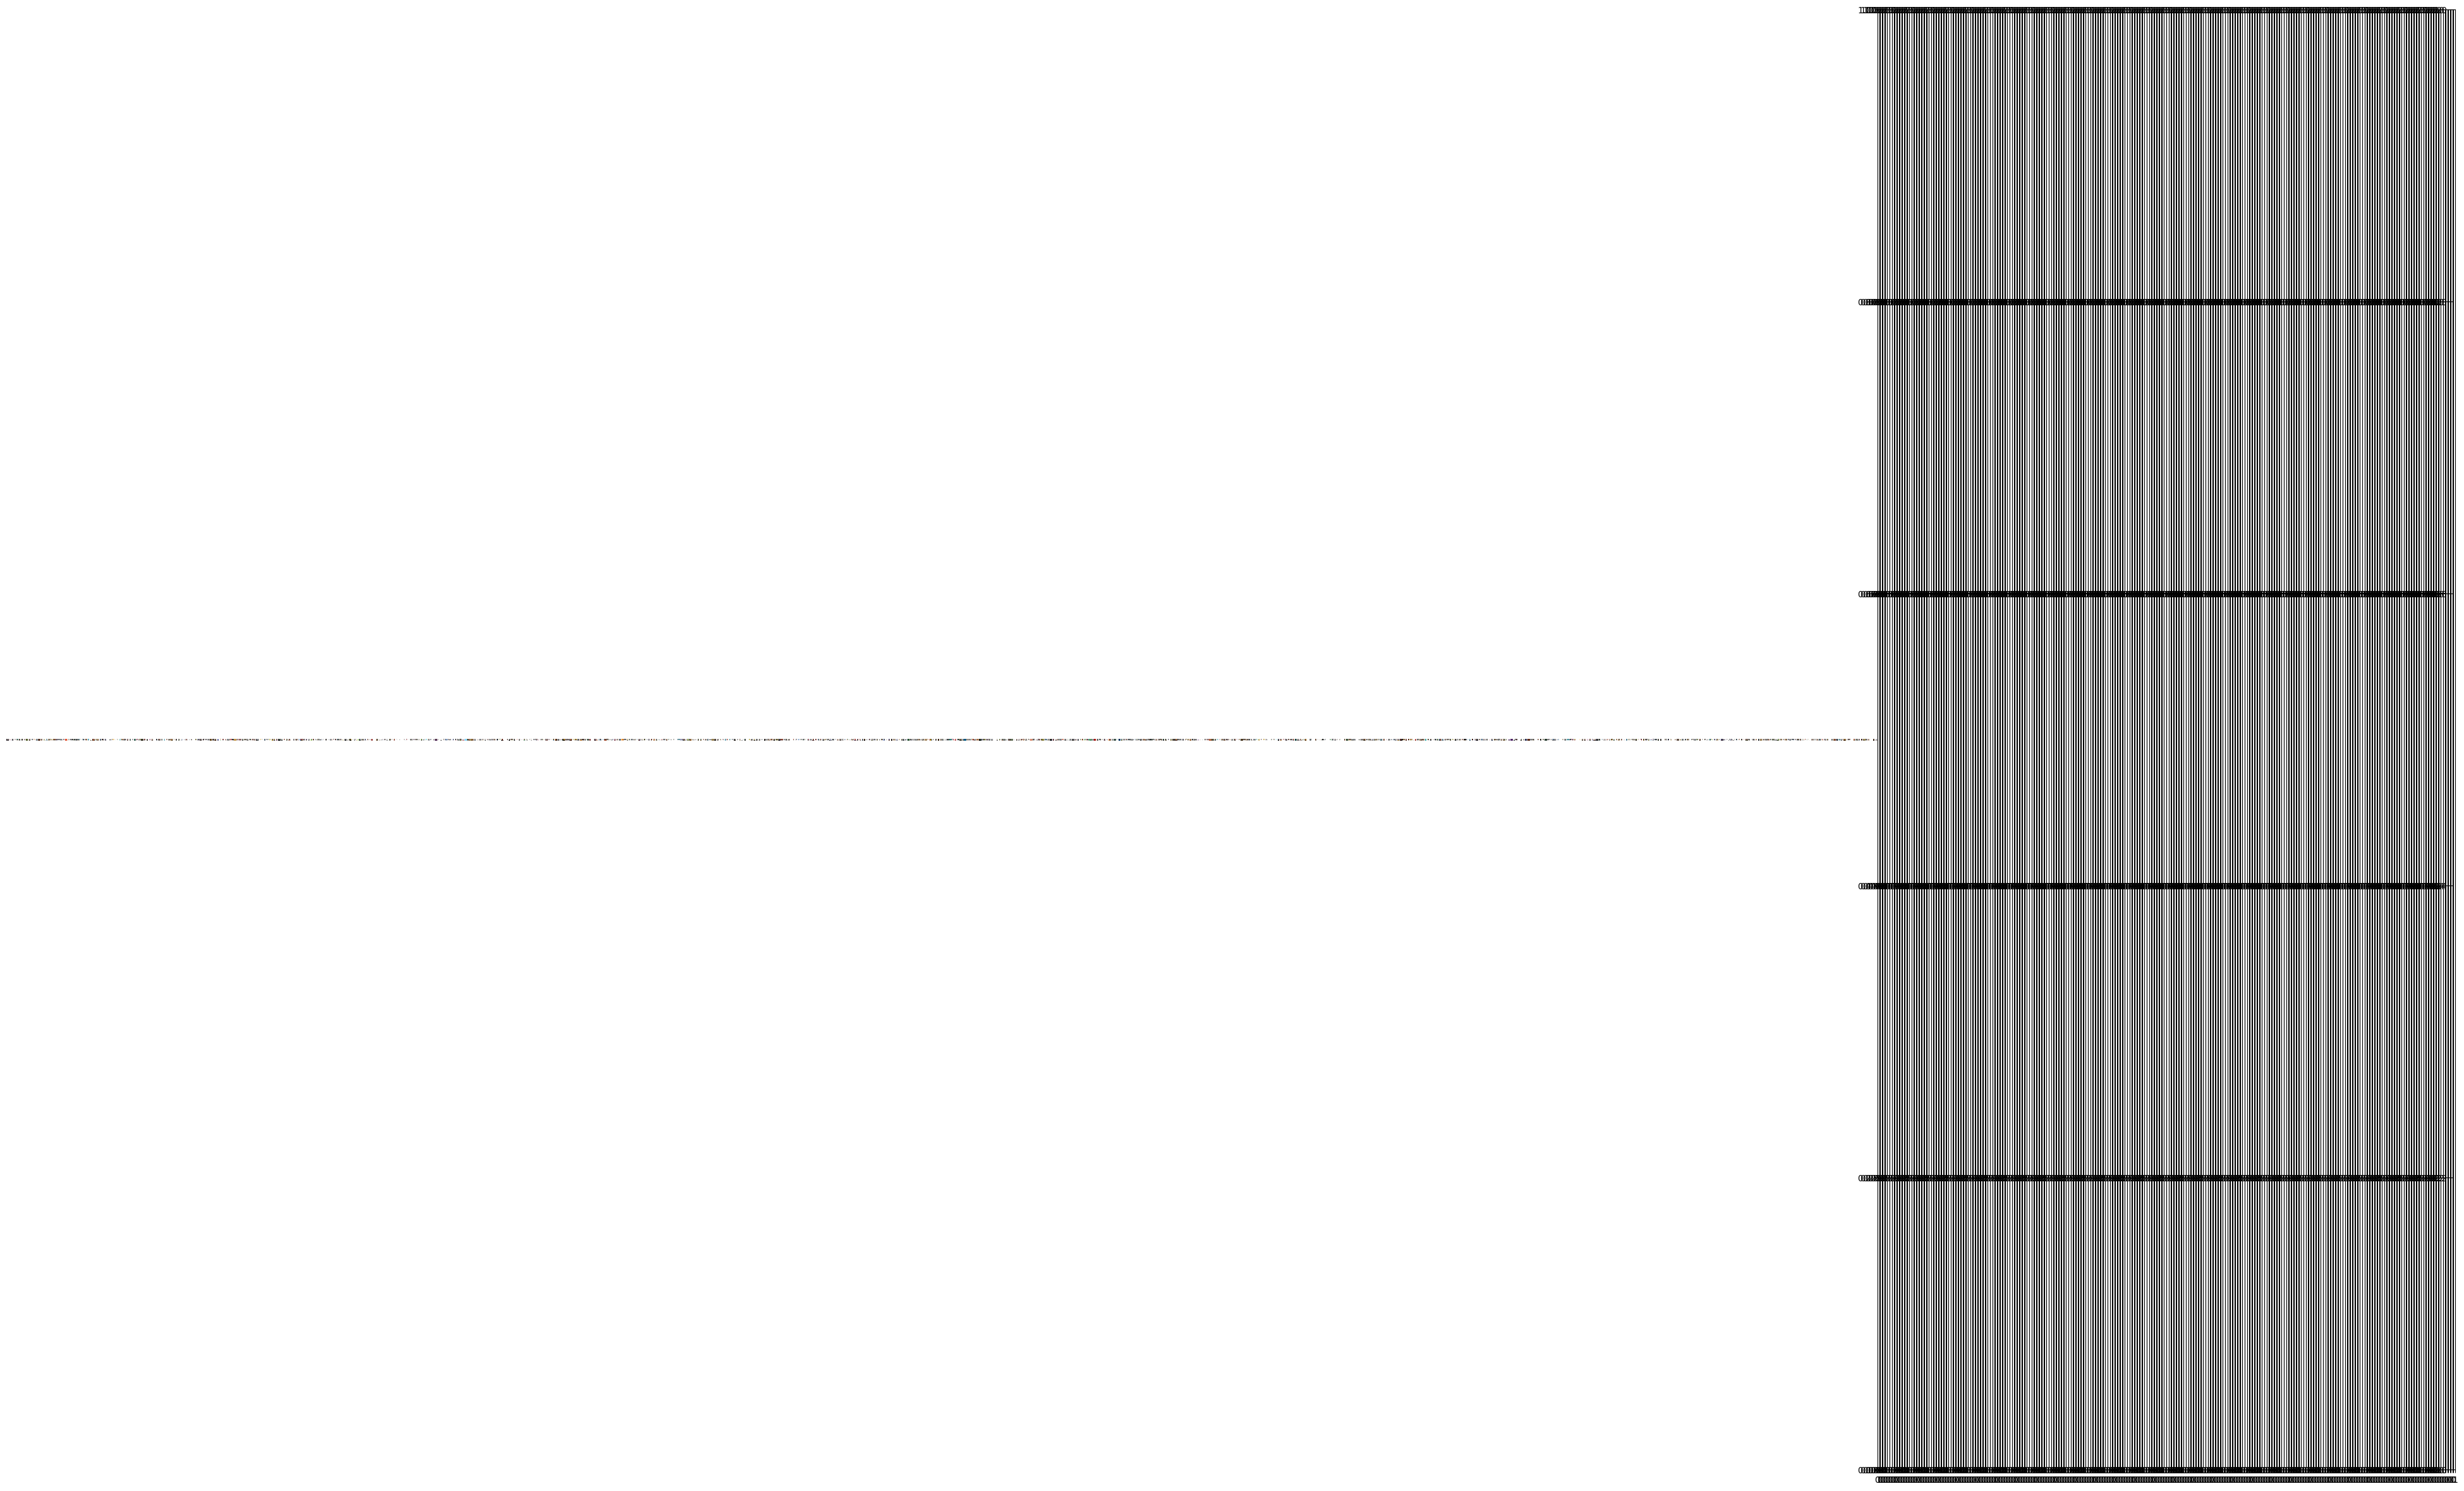

Before cleaning
Top 50 features when designation ['17ml' '40000' '40k' '60' 'acrylique' 'ad' 'age' 'air' 'august' 'cosplay'
 'costume' 'dark' 'donjons' 'dragon' 'dragons' 'dungeons' 'empire'
 'figurine' 'games' 'gamme' 'guerrier' 'halloween' 'heroclix' 'jeu' 'jeux'
 'led' 'lot' 'magic' 'masque' 'miniatures' 'modèle' 'métal' 'oop' 'partha'
 'party' 'peinture' 'pot' 'prince' 'ral' 'rôles' 'set' 'sigmar' 'space'
 'star' 'sw' 'table' 'visage' 'warhammer' 'wars' 'workshop']
Top 50 features when description ['10' '39' 'accessoires' 'age' 'ans' 'audio' 'batterie' 'bluetooth'
 'caractéristiques' 'carte' 'cosplay' 'costume' 'danse' 'différence'
 'distance' 'effrayant' 'enfant' 'figurine' 'fêtes' 'grâce' 'halloween'
 'image' 'jeu' 'latex' 'lecteur' 'led' 'lettre' 'lumière' 'magic' 'mask'
 'masque' 'matériel' 'mettre' 'monde' 'musique' 'plastique' 'plaît' 'port'
 'pouvez' 'produit' 'propos' 'qualité' 'rythme' 'tête' 'usb' 'vert'
 'vidéo' 'visage' 'voir' 'écran']
Top 50 features when designation+d

['dungeons',
 'set',
 'heroclix',
 'air',
 'guerrier',
 'chaos',
 'acrylique',
 'oop',
 'ad',
 'partha',
 'modèle',
 'wars',
 'table',
 'star',
 'pot',
 'marines',
 'ml',
 'space',
 'games',
 'rôles',
 'sw',
 'donjons',
 'jeux',
 'gamme',
 'prince',
 'august',
 'miniatures',
 'party',
 'warhammer',
 'métal',
 'sigmar',
 'lot',
 'peinture',
 'dragons',
 'ral',
 'pao',
 'dark',
 'hpp']

words found in 'description' NOT in 'designation': 38


['produit',
 'écran',
 'rythme',
 'propos',
 'effrayant',
 'pouvez',
 'tête',
 'matériel',
 'lecteur',
 'lumière',
 'port',
 'musique',
 'différence',
 'grâce',
 'sd',
 'usb',
 'ans',
 'voir',
 'qualité',
 'fêtes',
 'bluetooth',
 'image',
 'plastique',
 'enfant',
 'batterie',
 'mp',
 'plaît',
 'colors',
 'caractéristiques',
 'masques',
 'monde',
 'audio',
 'mettre',
 'mask',
 'plupart',
 'vert',
 'accessoires',
 'carte']

words found in both 'description' AND 'designation': 12


['figurine',
 'halloween',
 'danse',
 'cosplay',
 'masque',
 'visage',
 'age',
 'costume',
 'jeu',
 'led',
 'magic',
 'latex']

First 1000 entries for type 1280


,designation,description,prdtypecode
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,1280
8,Puzzle Scooby-Doo Avec Poster 2x35 Pieces,NaN,1280
21,Glitter Beach Barbie By Barbie,Original Barbie Doll. Contains glitter lotion..,1280
26,Modèle De Voiture 4pcs Alliage Métallique 1.9i...,4pcs alliage métallique 1.9in jante de roue po...,1280
49,100pcs Premium Bâtons Bracelets Neon Light Glo...,100PCS premium Bâtons Bracelets Neon Light Par...,1280
...,...,...,...
17585,Télécommande De Voiture Rc Pour 9115/9116 / Dj...,<p><b>La description:</b></p><br /><p> Contrôl...,1280
17600,1pc Mode Enfants Enfant Assemblée Bébé Cartoon...,1pc Mode pour enfants Bébé Enfant Cartoon Asse...,1280
17613,Tyrannosaurus Rex Dinosaur Soft Plastic Modèle...,Kids Interactive WalkingDinosaur Glowing And M...,1280
17625,Double Headed Quarter - Youre Always A Winner,Double Headed Quarter - Youre ALWAYS a winner,1280


Before cleaning
Top 50 features when designation ['10' '18' 'animal' 'animaux' 'baby' 'bleu' 'bois' 'bricolage' 'bébé'
 'cadeau' 'caméra' 'clay' 'disney' 'dji' 'doll' 'doudou' 'drone' 'enfant'
 'enfants' 'figurine' 'fpv' 'hélicoptère' 'jeu' 'jouet' 'jouets' 'lapin'
 'magideal' 'mignon' 'mini' 'modèle' 'noël' 'parfumée' 'peluche' 'pièces'
 'plat' 'poupée' 'puzzle' 'quadcopter' 'rc' 'rose' 'sac' 'set'
 'simulation' 'slime' 'stress' 'toy' 'toys' 'voiture' 'wifi' 'éducation']
Top 50 features when description ['10' '100' '1x' '39' '43' 'ans' 'batterie' 'bois' 'bébé' 'cadeau'
 'caractéristiques' 'charge' 'contenu' 'distance' 'doux' 'drone'
 'emballage' 'enfant' 'enfants' 'facile' 'fonction' 'forfait' 'grand'
 'haute' 'jeu' 'jouer' 'jouet' 'jouets' 'main' 'matériel' 'mode' 'modèle'
 'moteur' 'paquet' 'peluche' 'plastique' 'poids' 'poupée' 'pouvez'
 'produit' 'qualité' 'raison' 'rc' 'stress' 'super' 'temps' 'toy' 'tête'
 'voiture' 'vol']
Top 50 features when designation+description ['10' '100'

['figurine',
 'set',
 'rose',
 'animaux',
 'toys',
 'dji',
 'doll',
 'plat',
 'magideal',
 'quadcopter',
 'disney',
 'bleu',
 'doudou',
 'baby',
 'mignon',
 'parfumée',
 'fpv',
 'noël',
 'simulation',
 'mini',
 'slime',
 'éducation',
 'animal',
 'sac',
 'wifi',
 'clay',
 'caméra',
 'loisirs',
 'puzzle',
 'pièces',
 'lapin',
 'hélicoptère',
 'bricolage']

words found in 'description' NOT in 'designation': 33


['poids',
 'contenu',
 'produit',
 'télécommande',
 'charge',
 'vol',
 'emballage',
 'distance',
 'grand',
 'facile',
 'pouvez',
 'tête',
 'matériel',
 'forfait',
 'doux',
 'pc',
 'raison',
 'vêtements',
 'paquet',
 'ans',
 'fonction',
 'qualité',
 'haute',
 'main',
 'plastique',
 'mode',
 'batterie',
 'temps',
 'moteur',
 'inclus',
 'caractéristiques',
 'super',
 'jouer']

words found in both 'description' AND 'designation': 17


['drone',
 'toy',
 'pcs',
 'rc',
 'poupée',
 'cadeau',
 'bois',
 'enfants',
 'jeu',
 'stress',
 'voiture',
 'enfant',
 'jouet',
 'jouets',
 'modèle',
 'peluche',
 'bébé']

First 1000 entries for type 1281


,designation,description,prdtypecode
12,Peaceable Kingdom Wheres Bear? The Hide And Fi...,pCan my 2-year-old play a game? Yes Each game ...,1281
37,Nouveau 01h20 Échelle Alloy Mini Pull Back Voi...,NOUVEAU 01h20 échelle Alloy Mini Pull Back Voi...,1281
43,Non Toxique Effacer Slime Coul Beau Mélange Nu...,Non toxique Effacer Slime Couleur Beau mélange...,1281
52,Le Mot Le Plus Long,NaN,1281
135,Dinosaur Bubble Light Up Bulles Ventilat Avec ...,Dinosaur Bubble Light Up Bulles ventilateur av...,1281
...,...,...,...
41632,Hwa-Tu Korean Flower Card Game By Song Wol,pHwa-Tu (Flower Cards) is a traditional Korean...,1281
41638,Europa Universalis Jeu Sur Carte,Histoire de l'Europe et du monde de 1492 à 179...,1281
41697,5pcs L'enseignement Précoce De Bricolage Jouet...,5pcs L&#39;enseignement précoce de bricolage J...,1281
41700,Nourrisson Hochets Animal Mignon En Peluche Su...,Bébé hochets animal mignon en peluche suspendu...,1281


Before cleaning
Top 50 features when designation ['animal' 'animaux' 'board' 'bois' 'boue' 'bricolage' 'bébé' 'cadeau'
 'card' 'cards' 'cartes' 'cartoon' 'clay' 'doll' 'développement' 'edition'
 'enfants' 'familles' 'game' 'games' 'jeu' 'jeux' 'jouer' 'jouet' 'jouets'
 'magic' 'mignon' 'mini' 'modèle' 'musique' 'noël' 'nuage' 'parfumée'
 'party' 'peluche' 'poupée' 'putty' 'puzzle' 'relief' 'set' 'shen' 'slime'
 'société' 'star' 'stress' 'toy' 'voiture' 'warhammer' 'éducatif'
 'éducatifs']
Top 50 features when description ['100' '39' 'animaux' 'ans' 'bois' 'boue' 'bébé' 'cadeau' 'capacité'
 'caractéristiques' 'card' 'cards' 'cartes' 'contenu' 'couleurs'
 'emballage' 'enfant' 'enfants' 'facile' 'faire' 'feature' 'game' 'grand'
 'haute' 'idéal' 'jeu' 'jeux' 'jouer' 'jouet' 'jouets' 'joueurs' 'main'
 'matériel' 'mini' 'noël' 'paquet' 'peluche' 'plastique' 'players' 'poids'
 'poupée' 'produit' 'puzzle' 'qualité' 'slime' 'stress' 'super' 'toy'
 'utiliser' 'voiture']
Top 50 features when desi

['cartoon',
 'nuage',
 'société',
 'board',
 'modèle',
 'doll',
 'éducatif',
 'star',
 'shen',
 'développement',
 'ml',
 'games',
 'musique',
 'magic',
 'mignon',
 'parfumée',
 'putty',
 'relief',
 'party',
 'animal',
 'warhammer',
 'edition',
 'pcs',
 'clay',
 'éducatifs',
 'bricolage']

words found in 'description' NOT in 'designation': 26


['produit',
 'emballage',
 'players',
 'cards',
 'utiliser',
 'grand',
 'facile',
 'pouvez',
 'matériel',
 'parfait',
 'capacité',
 'pc',
 'paquet',
 'ans',
 'feature',
 'couleurs',
 'qualité',
 'haute',
 'main',
 'plastique',
 'enfant',
 'idéal',
 'faire',
 'caractéristiques',
 'super',
 'contenu']

words found in both 'description' AND 'designation': 24


['set',
 'animaux',
 'bois',
 'cartes',
 'jeu',
 'stress',
 'voiture',
 'toy',
 'jouet',
 'jouer',
 'poupée',
 'enfants',
 'boue',
 'game',
 'jeux',
 'noël',
 'slime',
 'mini',
 'card',
 'peluche',
 'cadeau',
 'puzzle',
 'jouets',
 'bébé']

First 1000 entries for type 1300


,designation,description,prdtypecode
24,Mini Wifi 720p Caméra Drone Rc Quadcopter 24 G...,Mini Wifi 720P Caméra Drone RC Quadcopter 24 G...,1300
59,Moakoada®Body Wrap Peau Autocollant Decal Pour...,Body Wrap peau autocollant Decal Pour DJI Phan...,1300
63,2.4g 6-Axis Wifi Fpv Drone 0.3mp Caméra Terre-...,NaN,1300
81,Maquette D'avion Protective Silicone Cover Cas...,Silicone CoverCase With Handheld Lanyard For D...,1300
104,Noch - 14222 - Modélisme Ferroviaire - Passere...,NaN,1300
...,...,...,...
16686,Version La Plus Récente Wingsland S6 Pocket Se...,NaN,1300
16693,Pvc Imperméable Carbone Grain Autocollants Gra...,PVC imperméable carbone Grain Autocollants gra...,1300
16702,Zop Puissance 14.8v 4500mah 4s 45c Batterie Xt...,ZOP Puissance 14.8V 4500mAh 4S 45C Batterie XT...,1300
16722,Dual 2 Battery Power Car Fast Charger Adapter ...,Dual 2 Battery Power Car Fast Charger Adapter ...,1300


Before cleaning
Top 50 features when designation ['10' '18' '2020' '43' '4ch' '4g' '4ghz' 'accessoires' 'air' 'altitude'
 'avion' 'batterie' 'brushless' 'camera' 'caméra' 'chargeur' 'crawler'
 'dji' 'drone' 'fpv' 'gimbal' 'générique' 'hd' 'hélice' 'maquette' 'mavic'
 'mini' 'moakoada' 'modèle' 'moteur' 'osmo' 'pièces' 'pliable' 'pocket'
 'portable' 'pro' 'protection' 'quadcopter' 'racing' 'rc' 'rechange' 'sac'
 'spark' 'support' 'traxxas' 'télécommande' 'voiture' 'wifi' 'zoom'
 'étanche']
Top 50 features when description ['10' '100' '1x' '39' '43' '7v' 'air' 'arrière' 'batterie' 'caméra'
 'caractéristiques' 'charge' 'chargeur' 'contrôle' 'câble' 'distance'
 'dji' 'droite' 'drone' 'durable' 'emballage' 'facile' 'fonction' 'fpv'
 'gauche' 'haute' 'hélice' 'inclus' 'matériel' 'mavic' 'minutes' 'mode'
 'moteur' 'paquet' 'poids' 'pro' 'produit' 'protection' 'quadcopter'
 'qualité' 'rc' 'support' 'temps' 'type' 'télécommande' 'usb' 'vitesse'
 'voiture' 'vol' 'wifi']
Top 50 features when desi

['traxxas',
 'brushless',
 'ch',
 'modèle',
 'osmo',
 'pocket',
 'rechange',
 'avion',
 'camera',
 'spark',
 'pliable',
 'moakoada',
 'mini',
 'sac',
 'racing',
 'mp',
 'étanche',
 'générique',
 'maquette',
 'accessoires',
 'ceeport',
 'crawler',
 'pao',
 'portable',
 'hpp',
 'gimbal',
 'pièces']

words found in 'description' NOT in 'designation': 27


['poids',
 'produit',
 'charge',
 'vol',
 'emballage',
 'droite',
 'contrôle',
 'distance',
 'câble',
 'hélice',
 'facile',
 'matériel',
 'vitesse',
 'arrière',
 'gauche',
 'paquet',
 'usb',
 'fonction',
 'qualité',
 'haute',
 'mode',
 'temps',
 'inclus',
 'caractéristiques',
 'durable',
 'minutes',
 'type']

words found in both 'description' AND 'designation': 23


['drone',
 'chargeur',
 'télécommande',
 'mah',
 'air',
 'dji',
 'voiture',
 'ghz',
 'pro',
 'hd',
 'protection',
 'quadcopter',
 'support',
 'fpv',
 'wifi',
 'rc',
 'batterie',
 'moteur',
 'pcs',
 'kv',
 'caméra',
 'nd',
 'mavic']

First 1000 entries for type 1301


,designation,description,prdtypecode
257,Enfants bébé tout-petits garçons Bébés filles ...,Enfants bébé Tout-petit bébé Garçons Filles Ca...,1301
289,9 Balles de Baby Foot Bonzini Balles en Liège ...,Diamètre de 35mm. Balles de baby foot en liège...,1301
945,Nouveau-né Bébé Garçons Filles Cartoon animaux...,Nouveau-nés garçons Bébés filles Cartoon anima...,1301
989,Cavalier 3 PCS / Set 23g En Aluminium Arbres E...,Cavalier 3 PCS / Set 23g En Aluminium Arbres E...,1301
1333,Ailette Fléchette Marathon Urban-Harrows,Ailette Marathon pour fléchette. La conception...,1301
...,...,...,...
84114,Boîte de 144 craies Master Rouge-Tweeten Fibre,Craies Master de couleur rouge.<br />Par boite...,1301
84168,Descente de Balle Centrale Baby Foot Bonzini-B...,Conduit central intérieure baby foot Bonzini.,1301
84258,Billard Table Américain Noir7ft tapis Rouge-Su...,Billard Table Américain Noir 7ft tapis rouge.<...,1301
84522,Housse Riley Noire Pour Queue 1/2-Riley,Longueur : 79 cm. Housse souple Noire. Pour qu...,1301


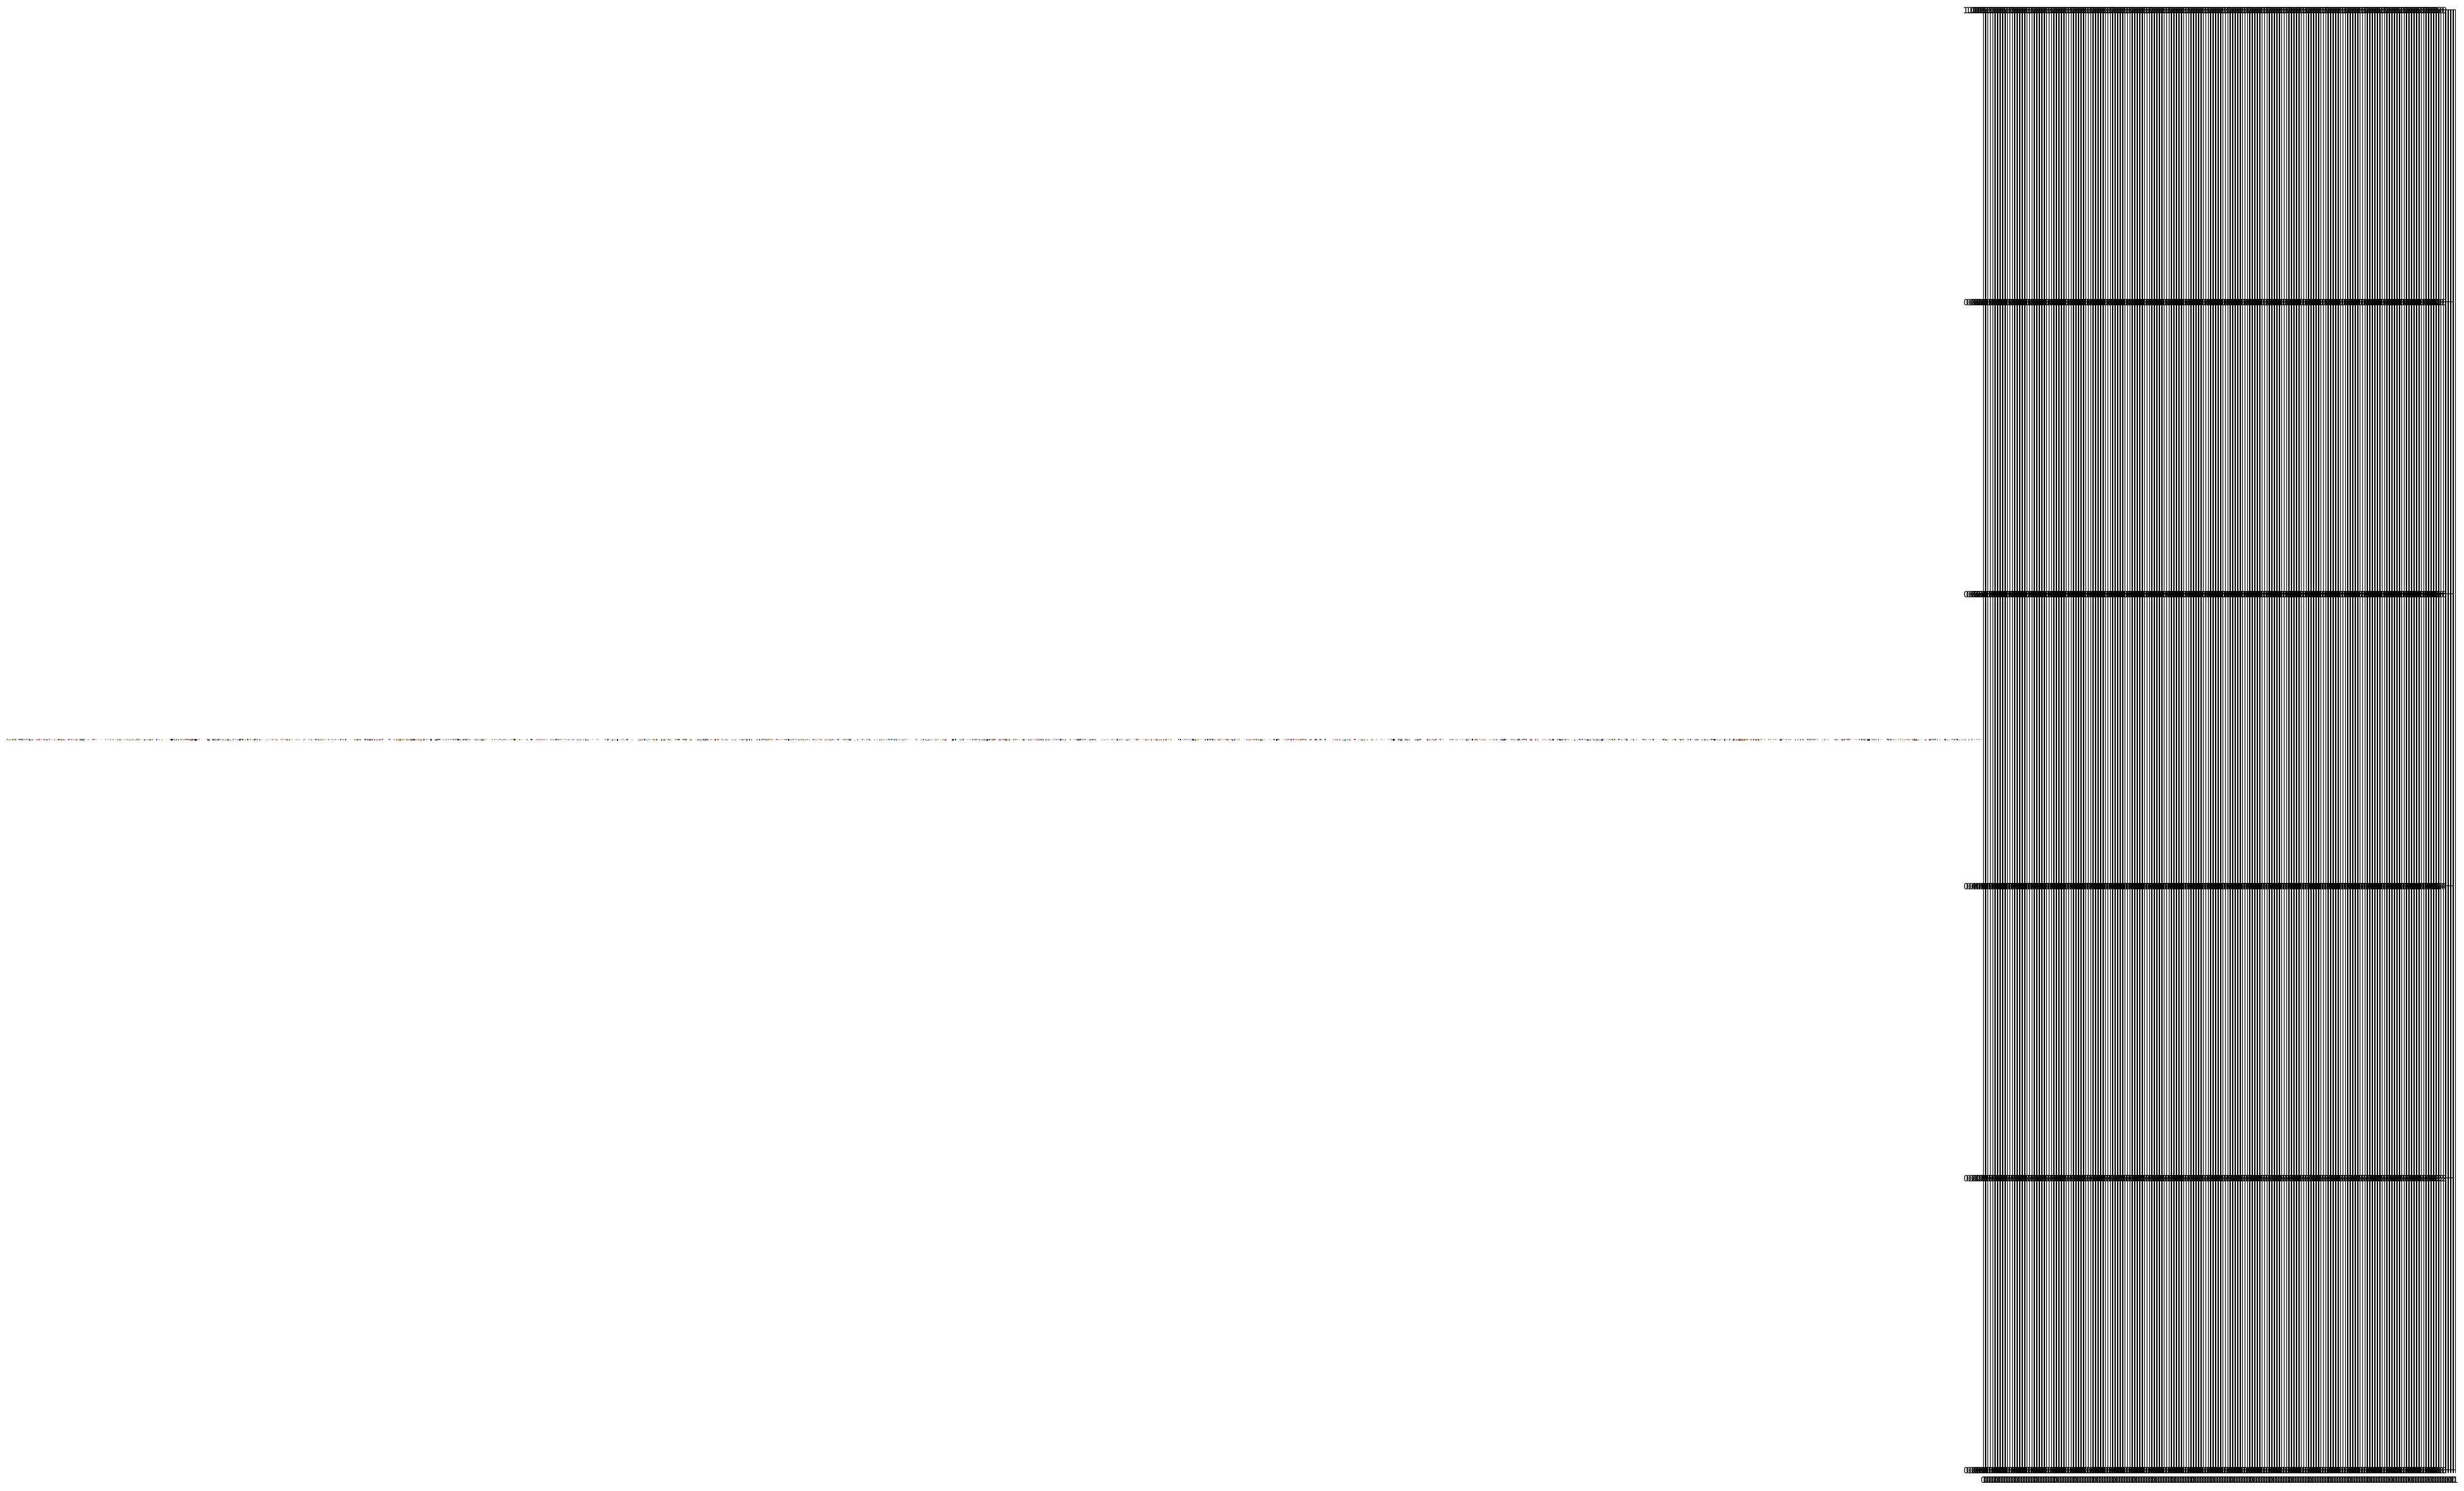

Before cleaning
Top 50 features when designation ['animaux' 'anti' 'aramith' 'auucne' 'baby' 'balles' 'bce' 'billard'
 'billes' 'bottes' 'bébé' 'bébés' 'cartoon' 'chaud' 'chaudes'
 'chaussettes' 'chaussons' 'chaussures' 'collants' 'coton' 'dérapant'
 'enfant' 'enfants' 'fille' 'filles' 'fléchette' 'fléchettes' 'foot'
 'garçon' 'garçons' 'harrows' 'jeu' 'lot' 'mignon' 'noël' 'né' 'paires'
 'petit' 'petits' 'queue' 'slip' 'slipper' 'sol' 'solides' 'stella' 'step'
 'supreme' 'table' 'tricotée' 'âge']
Top 50 features when description ['100' '12' '34' '39' 'ans' 'anti' 'belle' 'bébé' 'cadeau'
 'caractéristiques' 'cartoon' 'charmant' 'chaud' 'chaussettes' 'coffret'
 'confortable' 'contenu' 'coton' 'design' 'disponible' 'doux' 'enfants'
 'etiquette' 'facile' 'filles' 'fléchettes' 'gardez' 'garçons' 'grand'
 'haute' 'jeu' 'longueur' 'main' 'mal' 'matériaux' 'mois' 'molle' 'paire'
 'peau' 'pieds' 'plaît' 'produit' 'préfet' 'qualité' 'quotidien'
 'recommandé' 'sentiment' 'sexe' 'usage' 'âge']
To

['animaux',
 'chaussures',
 'auucne',
 'fléchette',
 'bce',
 'petit',
 'balles',
 'paires',
 'table',
 'collants',
 'billard',
 'chaudes',
 'queue',
 'sol',
 'foot',
 'billes',
 'bottes',
 'supreme',
 'dérapant',
 'aramith',
 'petits',
 'baby',
 'bébés',
 'mignon',
 'noël',
 'slipper',
 'enfant',
 'solides',
 'harrows',
 'fille',
 'lot',
 'chaussons',
 'slip',
 'tricotée',
 'step',
 'garçon',
 'stella']

words found in 'description' NOT in 'designation': 37


['produit',
 'design',
 'longueur',
 'information',
 'sentiment',
 'préfet',
 'grand',
 'facile',
 'etiquette',
 'gardez',
 'matériaux',
 'peau',
 'recommandé',
 'mois',
 'coffret',
 'doux',
 'sexe',
 'ans',
 'disponible',
 'qualité',
 'haute',
 'main',
 'confortable',
 'mal',
 'plaît',
 'pieds',
 'charmant',
 'caractéristiques',
 'belle',
 'cadeau',
 'paire',
 'étiquette',
 'molle',
 'quotidien',
 'months',
 'contenu',
 'usage']

words found in both 'description' AND 'designation': 13


['né',
 'cartoon',
 'coton',
 'garçons',
 'filles',
 'enfants',
 'jeu',
 'anti',
 'fléchettes',
 'âge',
 'chaussettes',
 'bébé',
 'chaud']

First 1000 entries for type 1302


,designation,description,prdtypecode
76,60ml Halloween Head Ghost Mélange Nuage Slime ...,60ML Halloween Head Ghost Mélange Nuage Slime ...,1302
79,Squishies Adorable Pingouin Squeeze Rising Slo...,Squishies adorable pingouin lente hausse Squee...,1302
114,Jouet Halloween Horror Grimace Night Terror Ma...,Halloween Pumpkin Ice Cream Slow Rising Collec...,1302
120,Trampoline Berg Elite Inground Rouge 430cm,Le BERG Elite InGround est le meilleur trampol...,1302
125,1pc Leurres 9cm Plastique Hardbass Appâts 8 Co...,1pc Leurres 9cm plastique Hardbass Appâts 8 co...,1302
...,...,...,...
32861,Doux Remplacement De Silicone Montre-Bracelet ...,Remplacement silicone souple bracelet bande po...,1302
32911,Nouveau Mode Sport Bracelet En Cuir Bracelet B...,Nouveau sport de mode en cuir Bracelet Bracele...,1302
32921,Gym Sports Case Armband Courir Jogging Exercic...,Gym Sports Case Armband Courir Jogging exercic...,1302
32971,Ballon De Volley Ball Match 216 Mm,<p>Ballon de volley match blanc 216 mm.</p><p>...,1302


Before cleaning
Top 50 features when designation ['1pc' 'air' 'anti' 'appât' 'appâts' 'balle' 'bande' 'bois' 'bracelet'
 'camping' 'eau' 'enfant' 'enfants' 'extérieur' 'filet' 'fitbit' 'goverie'
 'hausse' 'jeu' 'jouet' 'jouets' 'lampe' 'led' 'lent' 'lente' 'leurres'
 'ligne' 'lumière' 'mini' 'montre' 'parfumée' 'plastique' 'plein' 'poche'
 'pêche' 'randonnée' 'relief' 'rising' 'silicone' 'sport' 'squeeze'
 'squishies' 'stream' 'stress' 'super' 't6' 'torche' 'toy' 'trampoline'
 'yoga']
Top 50 features when description ['100' '1pc' '1x' '39' '43' 'acier' 'air' 'aluminium' 'ans' 'appât'
 'batterie' 'bracelet' 'cadeaux' 'camping' 'caractéristiques'
 'confortable' 'doux' 'durable' 'eau' 'emballage' 'enfants' 'facile'
 'fonction' 'haute' 'inclus' 'jouet' 'jouets' 'lampe' 'led' 'longueur'
 'lumière' 'matériel' 'mignons' 'paquet' 'plein' 'poche' 'poids' 'pouvez'
 'produit' 'protection' 'pêche' 'qualité' 'quantité' 'stress' 'style'
 'super' 'sécurité' 'trampoline' 'type' 'utiliser']
Top 50 feat

['minnow',
 'sport',
 'bois',
 'jeu',
 'randonnée',
 'squeeze',
 'torche',
 'balle',
 'bande',
 'leurres',
 'goverie',
 'filet',
 'stream',
 'parfumée',
 'ligne',
 'hausse',
 'relief',
 'yoga',
 'mini',
 'anti',
 'enfant',
 'plastique',
 'squishies',
 'montre',
 'pcs',
 'rising',
 'appâts',
 'silicone',
 'extérieur',
 'lent']

words found in 'description' NOT in 'designation': 30


['poids',
 'produit',
 'emballage',
 'longueur',
 'utiliser',
 'facile',
 'pouvez',
 'matériel',
 'sécurité',
 'mignons',
 'quantité',
 'environnement',
 'protection',
 'acier',
 'marque',
 'doux',
 'aluminium',
 'paquet',
 'ans',
 'fonction',
 'qualité',
 'haute',
 'cadeaux',
 'confortable',
 'batterie',
 'inclus',
 'caractéristiques',
 'durable',
 'style',
 'type']

words found in both 'description' AND 'designation': 20


['air',
 'led',
 'stress',
 'toy',
 'lumière',
 'plein',
 'enfants',
 'bracelet',
 'trampoline',
 'pc',
 'poche',
 'lente',
 'appât',
 'camping',
 'eau',
 'lampe',
 'super',
 'jouet',
 'jouets',
 'pêche']

First 1000 entries for type 1320


,designation,description,prdtypecode
62,Largo 3 En 1 Poussette Combinée Parasol Siège ...,Largo Poussette 3 en 1 <br> Combinée combinée ...,1320
124,Wood Puzzle 3d Lion 7 Pièces,NaN,1320
138,Siège Auto Et Rehausseur Disney Avec Dossier G...,NaN,1320
143,Coffre À Jouet En Osier Gris,NaN,1320
191,Tigex Bavoir A Enfiler 6 Mois+,NaN,1320
...,...,...,...
25293,Beco Aqua-Windel 12-18mon Sealife Blau Uni Slip,Beco Aqua-Windel 12-18Mon Sealife Blau Uni Slip,1320
25355,Bavoir Bébé Imprimé I Love London Bleu,NaN,1320
25416,Baninni Sac À Langer Bari Vert Bndb009-Gr,NaN,1320
25418,Mordedor Actividades Clopette Playgro 0m+,NaN,1320


Before cleaning
Top 50 features when designation ['air' 'aroma' 'auto' 'baby' 'bain' 'bandoulière' 'bavoir' 'biberon'
 'bleu' 'bois' 'bébé' 'canne' 'chaise' 'coton' 'coussin' 'diffuseur' 'dos'
 'enfant' 'enfants' 'femmes' 'féminine' 'hochet' 'housse' 'humidificateur'
 'imprimé' 'jouet' 'lampe' 'langer' 'led' 'lit' 'lot' 'magideal' 'main'
 'matelas' 'messenger' 'mode' 'mois' 'petit' 'porte' 'poussette' 'rose'
 'rouge' 'sac' 'sacs' 'set' 'silicone' 'siège' 'tapis' 'veilleuse'
 'voyage']
Top 50 features when description ['100' '1pc' '34' '39' '43' 'air' 'ans' 'auto' 'bureau' 'bébé' 'cadeau'
 'caractéristiques' 'châssis' 'conception' 'contenu' 'coton' 'design'
 'différence' 'dos' 'eau' 'emballage' 'enfant' 'enfants' 'face' 'facile'
 'grand' 'haute' 'lit' 'main' 'matériel' 'mode' 'mois' 'mso' 'nacelle'
 'plaît' 'poids' 'poussette' 'produit' 'qualité' 'raison' 'roues'
 'réglable' 'sac' 'siège' 'style' 'sécurité' 'type' 'usb' 'utilisation'
 'voyage']
Top 50 features when designation+descripti

['set',
 'rose',
 'porte',
 'housse',
 'matelas',
 'bois',
 'led',
 'petit',
 'langer',
 'magideal',
 'ml',
 'bain',
 'bleu',
 'sacs',
 'hochet',
 'baby',
 'bavoir',
 'uapavmp',
 'coussin',
 'bt',
 'humidificateur',
 'imprimé',
 'veilleuse',
 'damaier',
 'tapis',
 'lot',
 'pcs',
 'aroma',
 'messenger',
 'diffuseur',
 'chaise',
 'jouet']

words found in 'description' NOT in 'designation': 32


['poids',
 'produit',
 'design',
 'emballage',
 'élégant',
 'conception',
 'bureau',
 'grand',
 'facile',
 'réglable',
 'matériel',
 'sécurité',
 'face',
 'utilisation',
 'différence',
 'roues',
 'pc',
 'raison',
 'mso',
 'usb',
 'qualité',
 'haute',
 'xcm',
 'châssis',
 'plaît',
 'nacelle',
 'caractéristiques',
 'style',
 'type',
 'cadeau',
 'eau',
 'contenu']

words found in both 'description' AND 'designation': 18


['siège',
 'voyage',
 'auto',
 'lit',
 'air',
 'coton',
 'dos',
 'poussette',
 'main',
 'enfants',
 'mois',
 'bandoulière',
 'enfant',
 'mode',
 'sac',
 'femmes',
 'canne',
 'bébé']

First 1000 entries for type 1560


,designation,description,prdtypecode
10,Eames Inspired Sxw Chair - Pink - Black,The timeless DSW seat can now be paired with m...,1560
11,Fauteuil Chesterfield Brenton 100% Cuir De Buf...,Canapé et fauteuil chesterfield en cuir antiqu...,1560
14,Matelas Mémoire De Forme 180x200 X 20 Cm Très ...,MATELAS:<br />Â· Accueil : Ferme .<br />Â· Sou...,1560
32,2 Cagettes De Rangement Happy Life - 40 X 30 C...,Organisez et rangez de manière scandinave votr...,1560
78,Crochets Plafond Crochets Coupe À Vis Des Croc...,Plafond Crochets Coupe à vis des crochets Plan...,1560
...,...,...,...
16318,Chaise Isis Vintage Pied Noir Kare Design,<p>Un classique chez KARE cette chaise design ...,1560
16361,Jeu De Pieds Cylindriques O 7 Cm H 15 Cm Taupe...,<p>Général<br /><br />Type de Produit Pied de ...,1560
16368,Ensemble Nature 530 Sommier Tradition Graphic ...,<p>Optez pour le confort de l&#39;ensemble Nat...,1560
16380,Forme Table Silicone Tapis Nid D'abeille Carré...,Forme Table silicone Tapis Honeycomb carré Coa...,1560


Before cleaning
Top 50 features when designation ['acier' 'bain' 'bar' 'bois' 'boîte' 'bricolage' 'bureau' 'canapé'
 'chaise' 'chaises' 'co' 'confort' 'coussin' 'cuir' 'cuisine' 'design'
 'ensemble' 'essenzia' 'fauteuil' 'ferme' 'forme' 'fournitures'
 'inoxydable' 'kitchen' 'lit' 'lot' 'magasin' 'manger' 'massif' 'matelas'
 'meuble' 'mousse' 'mémoire' 'métal' 'noël' 'pcs' 'pieds' 'porte'
 'rangement' 'sac' 'salle' 'sommier' 'stockage' 'supplies' 'sweetheart93'
 'table' 'tabouret' 'tissu' 'vendu' 'zhufuwme']
Top 50 features when description ['100' '34' '39' '43' 'acier' 'anti' 'assise' 'bois' 'canapé'
 'caractéristiques' 'chaise' 'class' 'confort' 'confortable' 'couchage'
 'cuisine' 'design' 'dossier' 'durable' 'eau' 'facile' 'ferme' 'forme'
 'haute' 'hps' 'lit' 'livraison' 'longueur' 'matelas' 'matériel' 'meuble'
 'mousse' 'métal' 'pieds' 'plaît' 'poids' 'polyester' 'produit'
 'profondeur' 'qualité' 'rangement' 'sac' 'salle' 'siège' 'span'
 'structure' 'style' 'table' 'tissu' 'utiliser

['inoxydable',
 'mémoire',
 'boîte',
 'porte',
 'co',
 'cuir',
 'chaises',
 'bain',
 'magasin',
 'fournitures',
 'essenzia',
 'sommier',
 'ensemble',
 'bar',
 'sweetheart',
 'stockage',
 'supplies',
 'massif',
 'coussin',
 'fauteuil',
 'noël',
 'tabouret',
 'vendu',
 'lot',
 'kitchen',
 'pcs',
 'zhufuwme']

words found in 'description' NOT in 'designation': 27


['produit',
 'utiliser',
 'facile',
 'couchage',
 'dossier',
 'matériel',
 'intérieur',
 'structure',
 'polyester',
 'grâce',
 'pc',
 'raison',
 'assise',
 'livraison',
 'qualité',
 'haute',
 'anti',
 'confortable',
 'siège',
 'plaît',
 'maison',
 'inclus',
 'caractéristiques',
 'durable',
 'style',
 'eau',
 'moderne']

words found in both 'description' AND 'designation': 23


['décoration',
 'design',
 'ferme',
 'tissu',
 'matelas',
 'bois',
 'bureau',
 'table',
 'confort',
 'lit',
 'acier',
 'manger',
 'forme',
 'salle',
 'canapé',
 'cuisine',
 'sac',
 'métal',
 'pieds',
 'meuble',
 'rangement',
 'mousse',
 'chaise']

First 1000 entries for type 1920


,designation,description,prdtypecode
13,Paire De Voilages Imprimés Fantaisie,Paire de voilages droits fantaisie qui mettra ...,1920
38,4pcs Décor Coussin Indépendance Style Jeter Co...,4pcs Décor Coussin Independence Day Style de T...,1920
45,Rideau A Oeillets Plastique Polyester Uni Esse...,rêt-à-poser ce rideau s'installe facilement et...,1920
92,Coussin En Peluche Canapé Taille Coussin Throw...,NaN,1920
103,Canapé Mignon Lit Pour Chat Accueil Décoration...,Chien mignon Canapé-lit Décoration Pillow Fest...,1920
...,...,...,...
19630,Lin Fête Des Pères Taie Coussin D'un Canapé Co...,Lin Fête des Pères Coussin Taie un canapé conf...,1920
19633,4pc Citrouille D'halloween Fantôme Taie Décora...,4pc citrouille d&#39;Halloween Fantôme Taie Dé...,1920
19673,1pc Home Décor Housse De Coussin Graffi Style ...,1pc Home Décor Housse de coussin Graffi style ...,1920
19678,Cas Heureux Halloween Coussin En Lin Coussin S...,Heureux cas Halloween oreiller Linge Coussin C...,1920


Before cleaning
Top 50 features when designation ['100' 'accueil' 'bain' 'canapé' 'carré' 'case' 'coton' 'couette'
 'coussin' 'couverture' 'cover' 'cuisine' 'decor' 'décor' 'décoratif'
 'décoration' 'festival' 'foyer' 'géométrique' 'halloween' 'happy'
 'heureux' 'home' 'housse' 'imprimer' 'imprimé' 'joyeux' 'lin' 'linen'
 'linge' 'lit' 'maison' 'noël' 'oreiller' 'parure' 'pcs' 'peluche'
 'pillow' 'polyester' 'rideau' 's4sassy' 'set' 'simple' 'sofa' 'style'
 'taie' 'taies' 'tapis' 'throw' 'voiture']
Top 50 features when description ['100' '18' '34' '39' '45' '45cm' 'café' 'canapé' 'caractéristiques'
 'carré' 'comprendre' 'coton' 'coussin' 'couverture' 'cycle' 'différence'
 'décoration' 'eau' 'fermeture' 'forfait' 'forme' 'haute' 'home' 'housse'
 'inclus' 'intérieur' 'lavable' 'lavage' 'lin' 'lit' 'légère' 'main'
 'maison' 'matériel' 'mesure' 'oreiller' 'pc' 'permettre' 'place' 'plaît'
 'polyester' 'pouces' 'produit' 'qualité' 'raison' 'style' 'taie' 'type'
 'utilisé' 'écran']
Top 50 fea

['simple',
 'set',
 'halloween',
 'pillow',
 'accueil',
 'suan',
 'ssassy',
 'cover',
 'décoratif',
 'happy',
 'throw',
 'sofa',
 'voiture',
 'cc',
 'foyer',
 'zjj',
 'zheng',
 'bain',
 'taies',
 'couette',
 'imprimer',
 'kap',
 'décor',
 'decor',
 'imprimé',
 'noël',
 'linen',
 'xcm',
 'heureux',
 'tapis',
 'case',
 'pcs',
 'rideau',
 'linge',
 'festival']

words found in 'description' NOT in 'designation': 35


['produit',
 'écran',
 'légère',
 'utilisé',
 'place',
 'comprendre',
 'matériel',
 'lavable',
 'forfait',
 'intérieur',
 'lumière',
 'permettre',
 'café',
 'différence',
 'forme',
 'pc',
 'raison',
 'lavage',
 'qualité',
 'haute',
 'manuelle',
 'main',
 'déviation',
 'glissière',
 'confortable',
 'plaît',
 'cycle',
 'mesure',
 'inclus',
 'caractéristiques',
 'type',
 'eau',
 'fermeture',
 'contenu',
 'pouces']

words found in both 'description' AND 'designation': 15


['lin',
 'canapé',
 'coussin',
 'lit',
 'décoration',
 'coton',
 'style',
 'home',
 'housse',
 'carré',
 'taie',
 'polyester',
 'oreiller',
 'couverture',
 'maison']

First 1000 entries for type 1940


,designation,description,prdtypecode
200,Lot De 5 Sachet Chewing Gum Pastèque Fini 100g...,Lot de 5 Sachet Chewing Gum Pastèque Fini 100g...,1940
203,Tassimo Jacobs Espresso Rainforest Alliance Vé...,Tassimo Jacobs Espresso Rainforest Alliance Vé...,1940
406,Dolce Gusto Espresso 16 Caps. 96g,DOLCE GUSTO Espresso 16 Caps. 96g - 16 capsule...,1940
442,Twinings Gunpowder Thé Vert Menthe - Vrac/Boit...,<br />,1940
702,Haribo Gingembre-Citron Bonbons Bonbons Gélifi...,Les bonbons Haribo gingembre-citron sont des b...,1940
...,...,...,...
84630,Valfleuri Coquillettes - Pâtes D'alsace 7 Oeuf...,<br />,1940
84720,6x Boites 190g Rose - Bonbon Anis - Anis De,Boîte ronde Bonbons rose 190g Boîte ronde 190g...,1940
84811,Goldmännchen Thé Fleurs D'eté Orange Jasmin Th...,Partez en quête de fraîcheur pendant l&#39;été...,1940
84894,Nestle Ptite Recette Lentilles Jambon - 2 X 200g,NESTLE Ptite recette lentilles jambon - 2 x 20...,1940


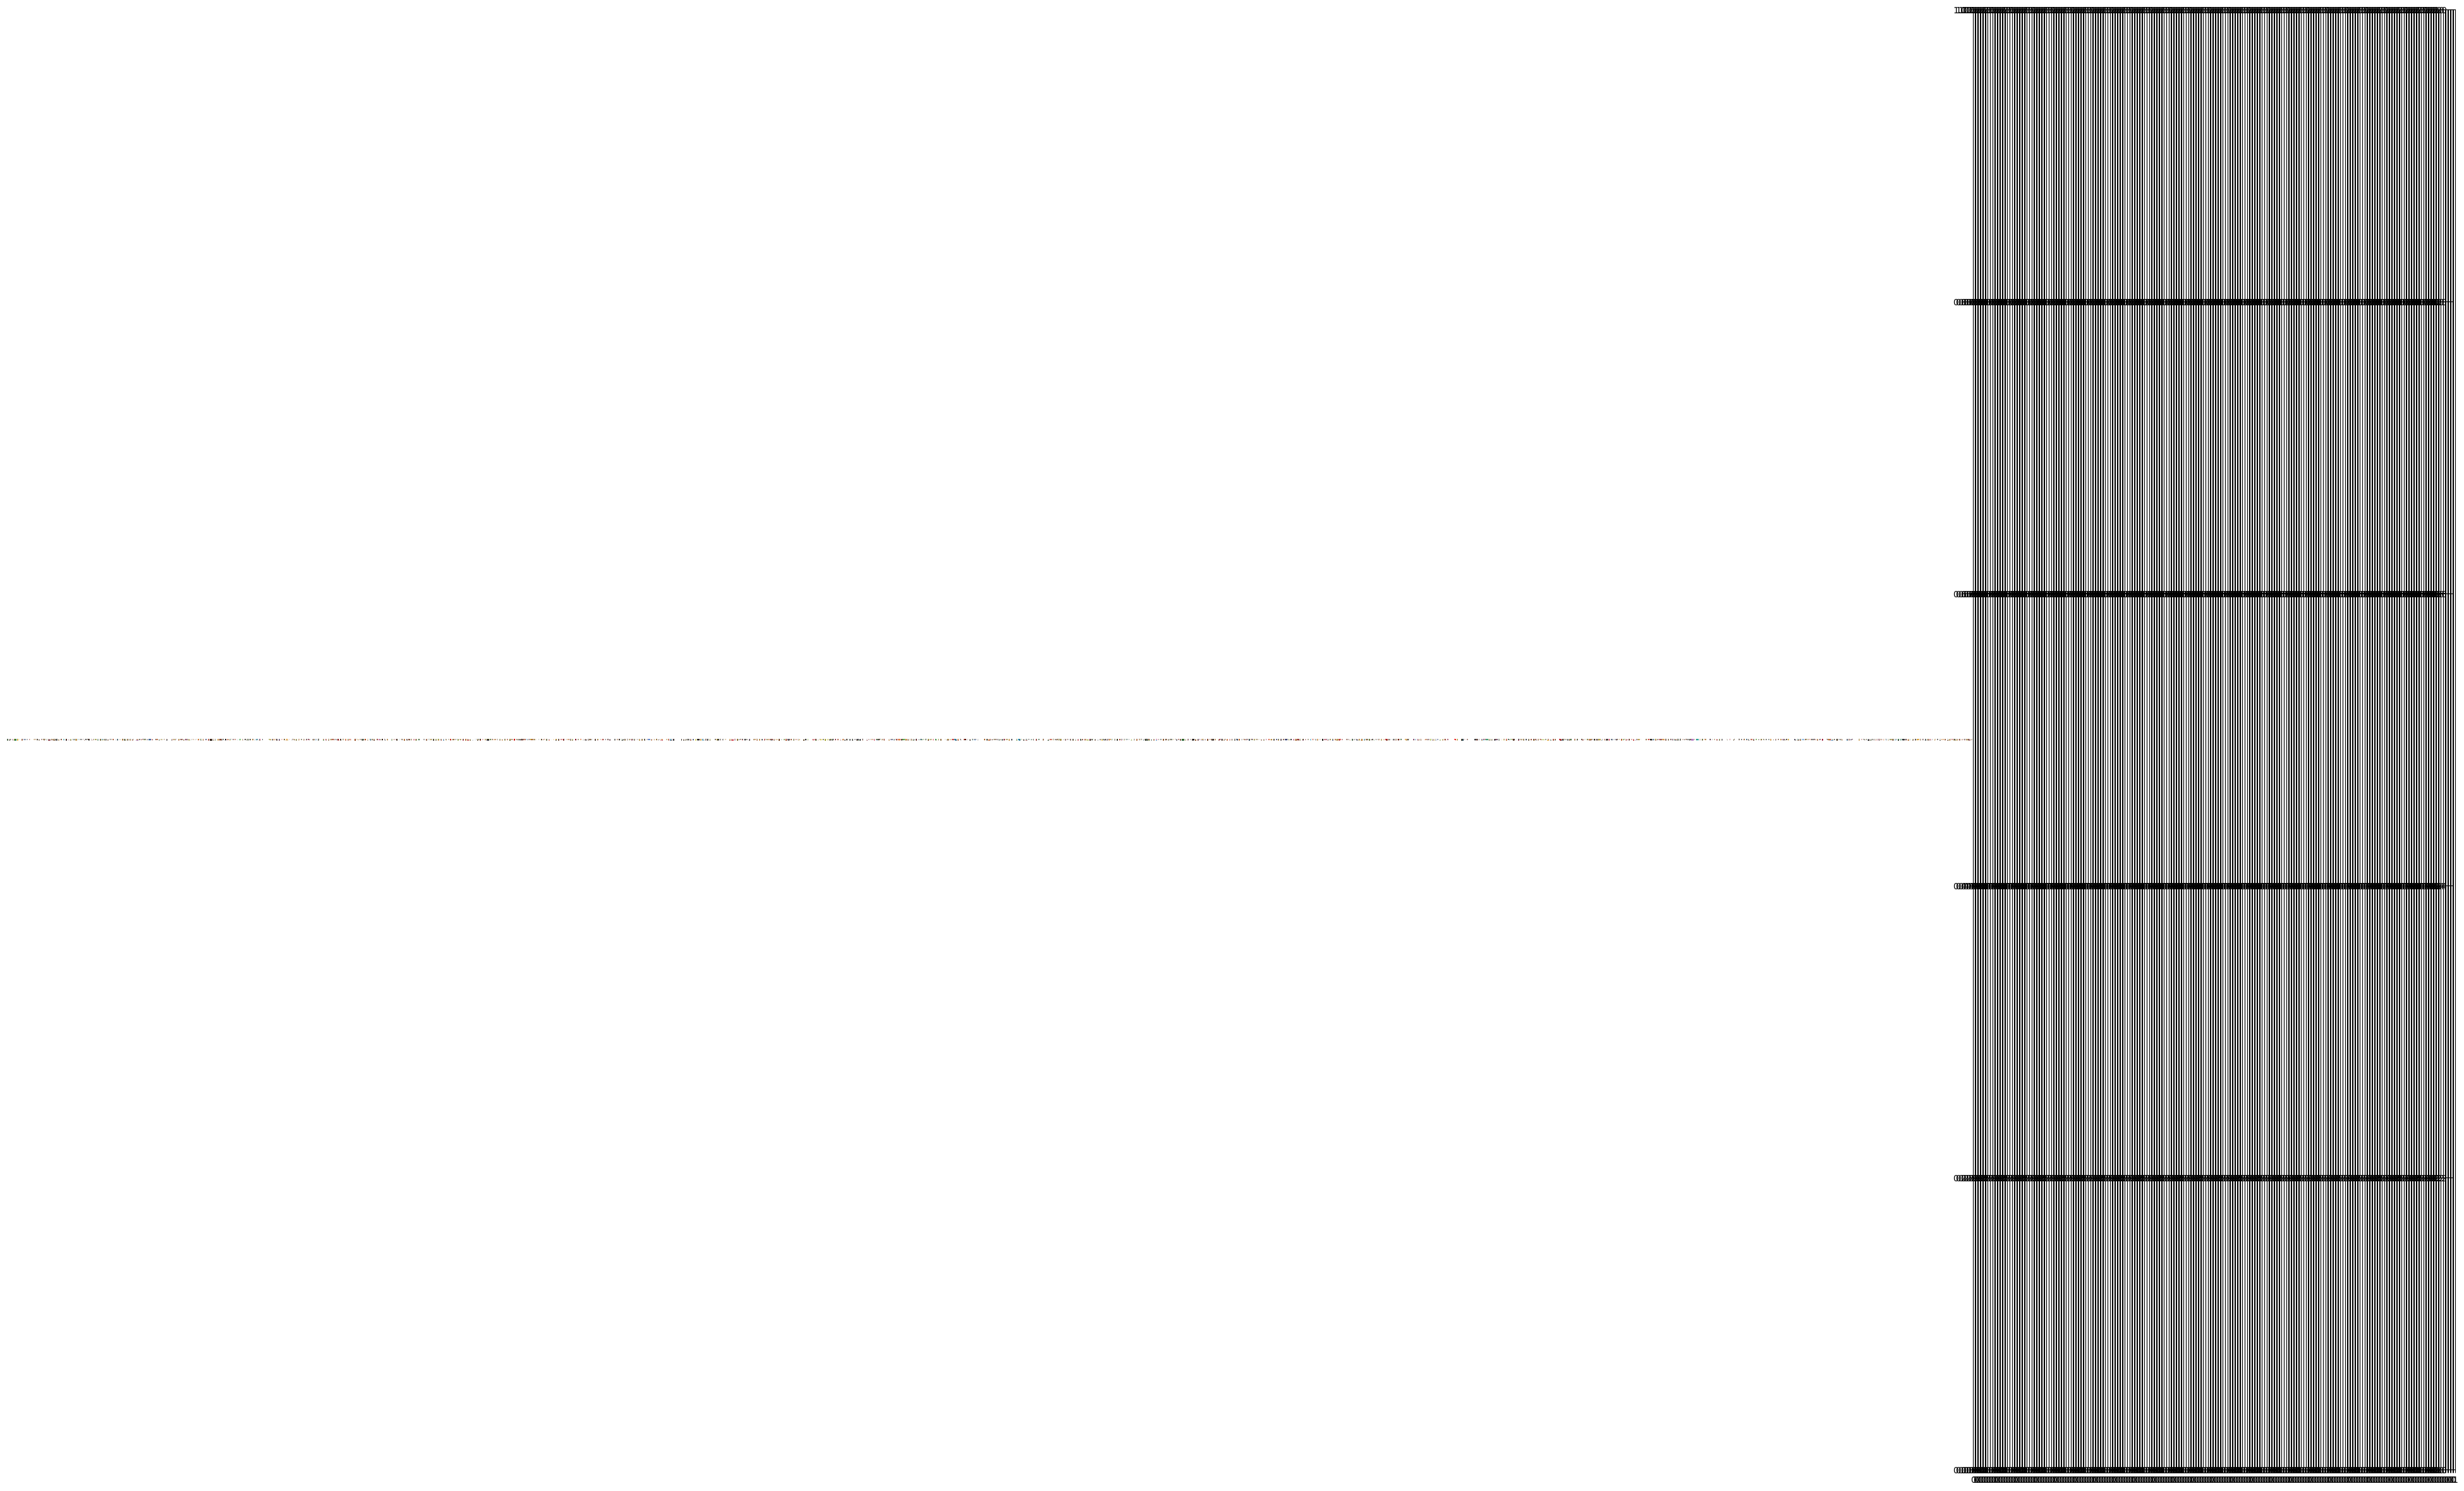

Before cleaning
Top 50 features when designation ['10' '100' '100g' '16' '20' '250' '250g' '39' '500' 'bio' 'bonbon'
 'bonbons' 'bur' 'cafe' 'café' 'capsules' 'chocolat' 'discs' 'dolce'
 'dosettes' 'eric' 'espresso' 'extra' 'fini' 'fruits' 'gluten' 'gr'
 'gusto' 'haribo' 'huile' 'lait' 'lot' 'maison' 'mini' 'ml' 'nescafé'
 'olive' 'orange' 'poudre' 'pâte' 'rouge' 'sac' 'sachet' 'sachets'
 'saveur' 'senseo' 'sucre' 'tassimo' 'thé' 'vert']
Top 50 features when description ['10' '100' '100g' '250' '34' '39' 'ail' 'arôme' 'arômes' 'beurre' 'bio'
 'bonbons' 'cacao' 'café' 'cannelle' 'capsules' 'chocolat' 'citron'
 'conditionnement' 'contenance' 'contient' 'dragées' 'eau' 'frais'
 'fruits' 'gluten' 'goût' 'grammes' 'général' 'huile' 'ingrédients' 'lait'
 'lot' 'marque' 'mois' 'origine' 'poids' 'poivre' 'poudre' 'produit'
 'pâte' 'sachet' 'saveur' 'sel' 'sirop' 'sucre' 'thé' 'type' 'vert' 'vin']
Top 50 features when designation+description ['10' '100' '100g' '16' '250' '34' '39' 'arôme' 'arôm

['bur',
 'espresso',
 'cl',
 'fini',
 'orange',
 'boites',
 'tassimo',
 'gusto',
 'cafe',
 'ml',
 'nescafé',
 'senseo',
 'haribo',
 'sachets',
 'confiture',
 'extra',
 'dosettes',
 'bonbon',
 'mini',
 'sac',
 'jacobs',
 'maison',
 'epices',
 'discs',
 'sauce',
 'dolce',
 'eric',
 'grains']

words found in 'description' NOT in 'designation': 28


['poids',
 'produit',
 'dragées',
 'sirop',
 'goût',
 'arômes',
 'beurre',
 'mois',
 'alimentaire',
 'marque',
 'préparation',
 'grammes',
 'général',
 'contenance',
 'cannelle',
 'sel',
 'ail',
 'frais',
 'muscade',
 'vin',
 'origine',
 'type',
 'eau',
 'contient',
 'ingrédients',
 'arôme',
 'conditionnement',
 'poivre']

words found in both 'description' AND 'designation': 22


['capsules',
 'cacao',
 'sucre',
 'saveur',
 'lait',
 'pâte',
 'gr',
 'thé',
 'café',
 'rouge',
 'chocolat',
 'fruits',
 'gluten',
 'sachet',
 'huile',
 'lot',
 'bio',
 'olive',
 'poudre',
 'vert',
 'citron',
 'bonbons']

First 1000 entries for type 2060


,designation,description,prdtypecode
30,Lampe De Lecture Rechargeable Led Lampe De Bea...,Nom de la marque:SYTH<br />Ampoules incluses:O...,2060
35,Decoration De Noel Christmas Snowman Kitchen T...,Christmas Snowman Kitchen Table Chair Covers H...,2060
36,30 Spots Encastrable Orientable Blanc Avec Gu1...,<b>Lot de 30 Spots encastrable orientable BLAN...,2060
67,Happy Halloween Sorcière Accueil Stickers Mura...,Happy Halloween Sorcière Accueil amovible Wall...,2060
77,Boite A Savons Metal Collection Moulin Rouge C...,NaN,2060
...,...,...,...
16574,Horloge 3d Wall Clock Diamonds Non-Ticking Sil...,3DWall Clock Diamonds Non-Ticking Silent Dazzl...,2060
16610,6pcs Ancienne En Bronze Créative Tiroir Armoir...,<div>Caractéristiques:</div><div>Fait d&#39;al...,2060
16614,Lot De Trois Oeuf,NaN,2060
16621,En Forme De Losange Peinture Spéciale Bricolag...,En forme de losange Peinture spéciale bricolag...,2060


Before cleaning
Top 50 features when designation ['3d' '5d' 'accueil' 'art' 'autocollant' 'bain' 'bois' 'bricolage'
 'broderie' 'bureau' 'cadeau' 'chambre' 'croix' 'cuisine' 'decor'
 'decoration' 'diamant' 'décor' 'décoration' 'fenêtre' 'halloween' 'home'
 'jardin' 'lampe' 'led' 'light' 'lujuik' 'lumière' 'lumières' 'magideal'
 'maison' 'mariage' 'mur' 'mural' 'murale' 'noël' 'party' 'pasted'
 'peinture' 'peintures' 'point' 'porte' 'salle' 'solaire' 'sticker'
 'stickers' 'strass' 'table' 'tapis' 'wall']
Top 50 features when description ['10' '100' '1pc' '1x' '34' '39' '43' 'batterie' 'besoin' 'bon'
 'bricolage' 'cadre' 'caractéristiques' 'chambre' 'contenu'
 'correspondant' 'couleurs' 'diamant' 'diamants' 'différence' 'décoration'
 'eau' 'emballage' 'facile' 'forfait' 'haute' 'image' 'lampe' 'led'
 'lumière' 'maison' 'matériel' 'mesure' 'mur' 'noël' 'paquet' 'parfait'
 'peinture' 'plaît' 'produit' 'qualité' 'raison' 'remarque' 'résine'
 'salle' 'style' 'surface' 'toile' 'type' 'utilise

['autocollant',
 'halloween',
 'lumières',
 'accueil',
 'porte',
 'bois',
 'murale',
 'mural',
 'bureau',
 'pasted',
 'table',
 'wall',
 'sticker',
 'broderie',
 'magideal',
 'bain',
 'home',
 'mariage',
 'point',
 'peintures',
 'décor',
 'decor',
 'stickers',
 'decoration',
 'cuisine',
 'tapis',
 'lujuik',
 'party',
 'croix',
 'strass',
 'solaire',
 'rideau',
 'cadeau',
 'fenêtre',
 'light',
 'art',
 'jardin']

words found in 'description' NOT in 'designation': 37


['produit',
 'surface',
 'emballage',
 'utiliser',
 'besoin',
 'facile',
 'matériel',
 'forfait',
 'cadre',
 'parfait',
 'différence',
 'éclairage',
 'pc',
 'raison',
 'images',
 'paquet',
 'couleurs',
 'qualité',
 'haute',
 'xcm',
 'image',
 'diamants',
 'résine',
 'batterie',
 'plaît',
 'mesure',
 'bon',
 'symboles',
 'caractéristiques',
 'style',
 'type',
 'eau',
 'mettre',
 'correspondant',
 'remarque',
 'toile',
 'contenu']

words found in both 'description' AND 'designation': 13


['pcs',
 'peinture',
 'décoration',
 'noël',
 'lumière',
 'diamant',
 'bricolage',
 'chambre',
 'led',
 'mur',
 'lampe',
 'salle',
 'maison']

First 1000 entries for type 2220


,designation,description,prdtypecode
82,Distributeur De Nourriture Tx2,Pour chat et petit chien. Grâce au timer intég...,2220
320,Chaîne Créative De Fission De Pied De Perroque...,<p><b>La description:</b></p><br /><p> 100% ne...,2220
338,Mode Pet Keep Warm Amour Decorationcoat Chien ...,Mode Pet Garder au chaud l&#39;amour Decoratio...,2220
354,Matelas Pour Chiens Taille M Beige,<p>Ce matelas pour chiens donnera à vos animau...,2220
355,Ruban Multicolre Topline Plus Vert 40mm,AKO TopLine Plus garantit une bonne conductivi...,2220
...,...,...,...
84705,4pcs Bottes Chien Imperméable Anti-Dérapant Ch...,<p><b>La description:</b></p><br /><p> Bottes ...,2220
84734,Pet Products La Vie De Chien Jacket Avec Poign...,Pet Products La vie de chien Jacket avec poign...,2220
84829,Paquet De 2 Couches Pour Perroquet En Forme De...,<p><b>La description:</b></p><br /><p> Tout ne...,2220
84838,Dog Pet Talonnage Bow Imprimer Vêtements Robe ...,&amp; Nbsp; Dog Pet talonnage Bow Imprimer Rob...,2220


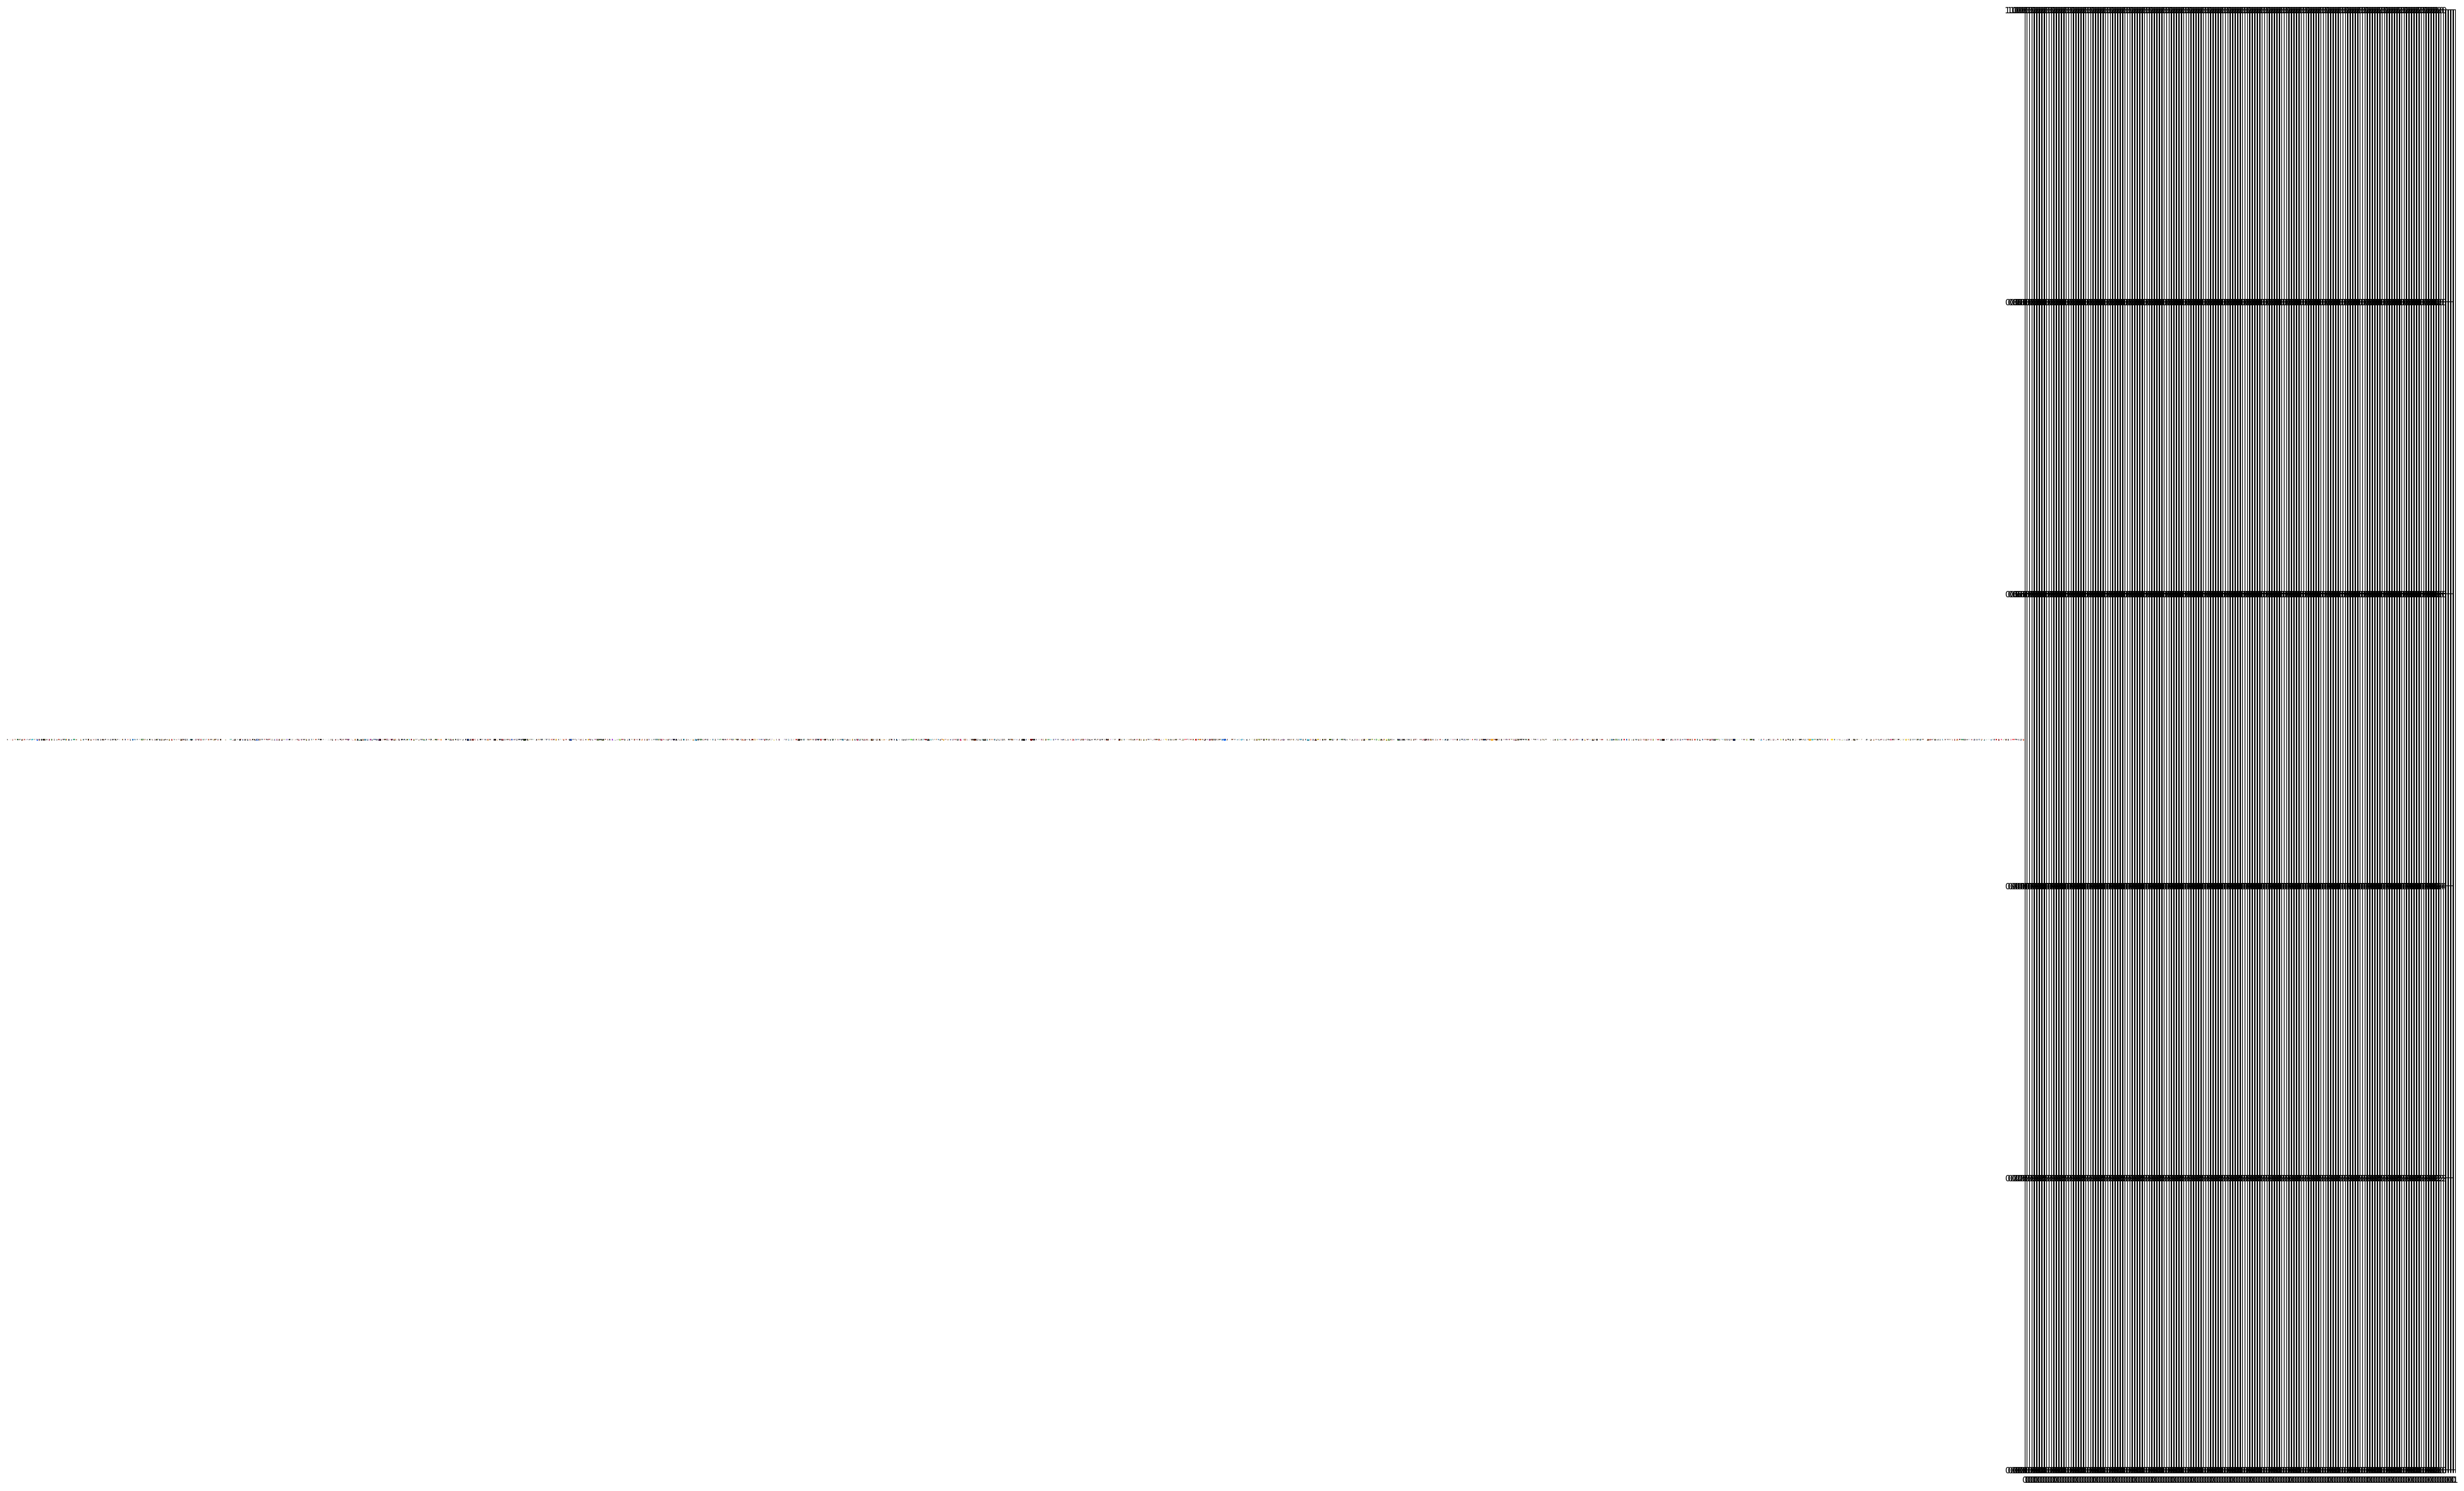

Before cleaning
Top 50 features when designation ['animal' 'animaux' 'anti' 'aquarium' 'automne' 'bleu' 'cat' 'chat'
 'chats' 'chaud' 'chien' 'chiens' 'chiot' 'collier' 'compagnie'
 'confortable' 'corde' 'costume' 'coton' 'coussin' 'dog' 'décoration'
 'forme' 'gilet' 'harnais' 'hiver' 'imperméable' 'jouet' 'jouets' 'laisse'
 'lit' 'magideal' 'maison' 'manteau' 'mat' 'mignon' 'mode' 'pet' 'petit'
 'pull' 'puppy' 'respirant' 'robe' 'réglable' 'sac' 'shirt' 'sweetheart93'
 'toy' 'veste' 'vêtements']
Top 50 features when description ['100' '11' '34' '39' 'animal' 'animaux' 'aquarium' 'caractéristiques'
 'chat' 'chaud' 'chien' 'chiens' 'collier' 'compagnie' 'confortable'
 'contenu' 'convient' 'cou' 'couleurs' 'différence' 'dog' 'durable'
 'durée' 'eau' 'env' 'facile' 'forfait' 'haute' 'hiver' 'images' 'jouet'
 'longueur' 'légèrement' 'main' 'matériel' 'mode' 'pet' 'plaît' 'poids'
 'poitrine' 'pouces' 'qualité' 'raison' 'remarque' 'réglable' 'style'
 'tour' 'type' 'vêtements' 'élément']
Top 

['cat',
 'décoration',
 'chiot',
 'shirt',
 'costume',
 'corde',
 'petit',
 'magideal',
 'lit',
 'harnais',
 'automne',
 'robe',
 'forme',
 'bleu',
 'laisse',
 'sweetheart',
 'mat',
 'mignon',
 'coussin',
 'coton',
 'chats',
 'anti',
 'sac',
 'maison',
 'gilet',
 'pcs',
 'respirant',
 'veste',
 'puppy',
 'pao',
 'imperméable',
 'manteau',
 'jouets']

words found in 'description' NOT in 'designation': 33


['poids',
 'contenu',
 'longueur',
 'légèrement',
 'tour',
 'inch',
 'facile',
 'matériel',
 'forfait',
 'xl',
 'différence',
 'env',
 'pc',
 'raison',
 'images',
 'lb',
 'couleurs',
 'qualité',
 'haute',
 'main',
 'plaît',
 'durée',
 'mesure',
 'élément',
 'caractéristiques',
 'durable',
 'style',
 'type',
 'eau',
 'remarque',
 'poitrine',
 'cou',
 'pouces']

words found in both 'description' AND 'designation': 17


['vêtements',
 'collier',
 'dog',
 'animaux',
 'chiens',
 'jouet',
 'aquarium',
 'pet',
 'animal',
 'chien',
 'confortable',
 'mode',
 'compagnie',
 'chat',
 'hiver',
 'chaud',
 'réglable']

First 1000 entries for type 2280


,designation,description,prdtypecode
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,2280
5,Afrique Contemporaine N° 212 Hiver 2004 - Doss...,NaN,2280
19,Monde Illustre (Le) N° 3083 Du 20/01/1917 - L'...,NaN,2280
28,Univers (L') N° 249 Du 12/09/1854 - France - P...,NaN,2280
44,Diagrammes N° 26 Du 01/04/1959 - Le Siecle Du ...,NaN,2280
...,...,...,...
17843,Vieilles Maisons Francaises N°125 - Avant-Prop...,NaN,2280
17883,Le Journal Du Dimanche / 15-05-2005 N°3045 : S...,NaN,2280
17976,Tintin N° 29 Du 17/07/1984 - Thorgal - Les ...,NaN,2280
17979,Nouvel Obs Tele Cine Radio (Le) N° 2081 Du 25/...,NaN,2280


Before cleaning
Top 50 features when designation ['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28'
 '2p' '30' 'art' 'contre' 'dossier' 'figaro' 'francaise' 'guerre'
 'histoire' 'illustre' 'jean' 'journal' 'magazine' 'monde' 'nouvelle'
 'paris' 'petit' 'politique' 'presse' 'revue' 'série' 'vie']
Top 50 features when description ['39' 'art' 'article' 'articles' 'charles' 'chronique' 'collection'
 'courrier' 'degats' 'dessin' 'em' 'espagne' 'etat' 'exposition' 'femmes'
 'fin' 'georges' 'grand' 'grande' 'gravure' 'gravures' 'guerre'
 'hebdomadaire' 'histoire' 'illustré' 'jean' 'journal' 'monde' 'nouvelle'
 'page' 'pages' 'paris' 'paul' 'pays' 'petit' 'photo' 'pierre' 'pleine'
 'revue' 'ruines' 'saint' 'semaine' 'sommaire' 'special' 'suite' 'texte'
 'théâtre' 'tour' 'vie' 'vue']
Top 50 features when designation+description ['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '

['europe',
 'nord',
 'equipe',
 'aujourd',
 'dossier',
 'auto',
 'nouvelles',
 'figaro',
 'mars',
 'illustre',
 'arts',
 'action',
 'moto',
 'ans',
 'mort',
 'francais',
 'bulletin',
 'annee',
 'film',
 'francaise',
 'avril',
 'sports',
 'parisien',
 'presse',
 'mode',
 'match',
 'contre',
 'maison',
 'tele',
 'magazine',
 'série',
 'general',
 'politique']

words found in 'description' NOT in 'designation': 33


['nature',
 'ruines',
 'pays',
 'fin',
 'semaine',
 'marie',
 'texte',
 'femmes',
 'tour',
 'etat',
 'pleine',
 'articles',
 'illustré',
 'charles',
 'degats',
 'grande',
 'sommaire',
 'suite',
 'hebdomadaire',
 'pages',
 'courrier',
 'photo',
 'page',
 'georges',
 'gravure',
 'collection',
 'théâtre',
 'espagne',
 'chronique',
 'exposition',
 'article',
 'gravures',
 'vue']

words found in both 'description' AND 'designation': 17


['art',
 'vie',
 'paris',
 'pierre',
 'paul',
 'revue',
 'nouvelle',
 'monde',
 'dessin',
 'special',
 'saint',
 'guerre',
 'journal',
 'jean',
 'petit',
 'grand',
 'histoire']

First 1000 entries for type 2403


,designation,description,prdtypecode
16,Walter Scott Oeuvres Complètes Tomes 3456 10 E...,NaN,2403
51,"One Piece Log 36 ""Impel Down Partie 2""",NaN,2403
54,Fate/Zero - Lot Mangas - Tome 1 À 5,NaN,2403
57,Lot De 5 Livres Grans Peintres,NaN,2403
61,Lot Pf38 - 15 Marque-Pages (Illustrations Vint...,NaN,2403
...,...,...,...
18051,Lot Revues Madame Figaro N°22617 Spécial Style...,NaN,2403
18109,Lot 3 Livres Partitions Alto (Et Piano) Debuta...,NaN,2403
18111,World War Hulk Mensuel Série 1-6 Plus 2 Hors S...,NaN,2403
18134,Lot De 10 Livres De 1959 À 1964 : J.Bommart 2 ...,NaN,2403


Before cleaning
Top 50 features when designation ['10' '11' '12' '13' '15' '18' '20' '34' '39' 'année' 'bd' 'cd'
 'collection' 'comics' 'complet' 'complète' 'edition' 'editions' 'grand'
 'guerre' 'histoire' 'interview' 'intégrale' 'jean' 'journal' 'livre'
 'livres' 'lot' 'magazine' 'marque' 'marvel' 'monde' 'numéros' 'pages'
 'paris' 'partitions' 'piano' 'poche' 'revue' 'revues' 'romans' 'série'
 'tome' 'tomes' 'vie' 'vol' 'volume' 'volumes' 'édition' 'éditions']
Top 50 features when description ['10' '12' '14' '15' '22' '30' '39' '43' 'ailleurs' 'amis' 'bon' 'charles'
 'collection' 'couverture' 'couvertures' 'dos' 'edition' 'envoi' 'format'
 'français' 'frottements' 'gaulle' 'général' 'histoire' 'ii' 'jean'
 'jeune' 'jour' 'jours' 'livre' 'livres' 'lot' 'maigret' 'michel'
 'numéros' 'ouvrages' 'pages' 'paris' 'pierre' 'police' 'rapide' 'soigné'
 'temps' 'tome' 'tomes' 'vie' 'vol' 'volumes' 'éditions' 'état']
Top 50 features when designation+description ['10' '11' '12' '15' '18' '20' '

['interview',
 'revue',
 'complet',
 'années',
 'petit',
 'grand',
 'année',
 'magazines',
 'partitions',
 'comics',
 'manga',
 'marque',
 'piano',
 'intégrale',
 'poche',
 'marvel',
 'bd',
 'editions',
 'revues',
 'volume',
 'journal',
 'op',
 'cd',
 'monde',
 'édition',
 'romans',
 'magazine',
 'albums',
 'art',
 'série',
 'encyclopédie']

words found in 'description' NOT in 'designation': 31


['amis',
 'ailleurs',
 'jeune',
 'soigné',
 'décembre',
 'police',
 'français',
 'titres',
 'gaulle',
 'dos',
 'maigret',
 'charles',
 'rousseurs',
 'couvertures',
 'jour',
 'frottements',
 'homme',
 'ans',
 'michel',
 'général',
 'état',
 'ii',
 'temps',
 'bon',
 'envoi',
 'hommes',
 'rapide',
 'jours',
 'format',
 'couverture',
 'ouvrages']

words found in both 'description' AND 'designation': 19


['vol',
 'numéros',
 'jean',
 'livres',
 'tomes',
 'vie',
 'tome',
 'volumes',
 'éditions',
 'guerre',
 'complète',
 'paris',
 'livre',
 'pages',
 'edition',
 'lot',
 'histoire',
 'collection',
 'pierre']

First 1000 entries for type 2462


,designation,description,prdtypecode
25,Dsi + Chargeur + Sacoche + 12 Jeux,NaN,2462
71,Xbox One 500 Giga Avc 3jeux Une Manette,NaN,2462
86,Xbox 360 Élite Noire 250go + 5 Jeux + Une Mane...,NaN,2462
238,Clementoni - 62580.2 - Jouet De Premier Age - ...,NaN,2462
324,Lot - Baldur&#39;S Gate - Dark Alliance Ii - 2...,NaN,2462
...,...,...,...
57753,Xbox One 1 To,NaN,2462
57764,Élément De Jeu - Jaquette De Remplacement - Ha...,NaN,2462
57860,Console Wii U + 5 Jeux,Wii U avec 5 jeux + Arene Skylanders 16 pièges...,2462
57867,Lot De 5 Power Discs Disney Infinity,NaN,2462


Before cleaning
Top 50 features when designation ['250' '360' '43' '500' 'accessoires' 'big' 'boite' 'box' 'boy' 'carte'
 'casque' 'cd' 'collection' 'console' 'dragon' 'ds' 'edition' 'ensemble'
 'fifa' 'game' 'jaquette' 'jeu' 'jeux' 'kinect' 'lot' 'manette' 'manettes'
 'mario' 'microsoft' 'nintendo' 'noire' 'notice' 'pack' 'pc' 'photos'
 'playstation' 'ps1' 'ps2' 'ps3' 'ps4' 'remplacement' 'slim' 'sony'
 'super' 'video' 'vidéo' 'voir' 'wii' 'xbox' 'élément']
Top 50 features when description ['360' '39' '43' '500' 'button' 'casque' 'charge' 'chargeur' 'conception'
 'console' 'controller' 'contrôleur' 'contrôleurs' 'câble' 'câbles'
 'double' 'duty' 'era' 'features' 'fifa' 'fil' 'filaire' 'gta' 'halo'
 'jeu' 'jeux' 'kinect' 'manette' 'manettes' 'mario' 'new' 'noire' 'pc'
 'playstation' 'pro' 'ps4' 'rapide' 'slim' 'super' 'support' 'touch'
 'téléphone' 'usb' 'version' 'wars' 'wii' 'wireless' 'xbox' 'zelda'
 'édition']
Top 50 features when designation+description ['360' '39' '43' '500' 'boi

['promo',
 'advance',
 'photos',
 'boite',
 'ensemble',
 'remplacement',
 'jaquette',
 'vidéo',
 'game',
 'blanche',
 'voir',
 'grosse',
 'video',
 'dragon',
 'big',
 'notice',
 'sega',
 'ds',
 'edition',
 'nintendo',
 'microsoft',
 'lot',
 'skylanders',
 'élément',
 'collection',
 'cd',
 'box',
 'pack',
 'sony',
 'boy',
 'accessoires',
 'carte']

words found in 'description' NOT in 'designation': 32


['chargeur',
 'charge',
 'conception',
 'version',
 'câble',
 'bros',
 'wars',
 'double',
 'halo',
 'pro',
 'fil',
 'era',
 'câbles',
 'support',
 'wireless',
 'usb',
 'gta',
 'filaire',
 'contrôleur',
 'new',
 'dual',
 'contrôleurs',
 'controller',
 'touch',
 'édition',
 'téléphone',
 'zelda',
 'dualshock',
 'button',
 'rapide',
 'chargement',
 'features']

words found in both 'description' AND 'designation': 18


['mario',
 'duty',
 'manettes',
 'slim',
 'jeux',
 'ps',
 'kinect',
 'manette',
 'noire',
 'console',
 'wii',
 'casque',
 'jeu',
 'super',
 'playstation',
 'fifa',
 'pc',
 'xbox']

First 1000 entries for type 2522


,designation,description,prdtypecode
7,Conquérant Sept Cahier Couverture Polypro 240 ...,CONQUERANT CLASSIQUE Cahier 240 x 320 mm seyès...,2522
15,Zenith Pince Agrafeuse 591 N°10 Coloris Noir,Pince agrafeuse 591 N°10. Capot en ABS. Dispos...,2522
17,Mod Podge Dishwasher Safe Gloss 8oz,NaN,2522
27,Faber-Castell Lot De 3 Crayons De Couleur Poly...,FABER-CASTELL Crayon de couleur POLYCHROMOS ve...,2522
33,Lindner 2365-2115ce Coin Case Nera Xl With 3 T...,Timeless elegance a clear design versatility f...,2522
...,...,...,...
17576,Carnet De Notes Bloc-Notes Cahier Modèle Anima...,Taille: En format A5 (144 cm x 21 cm) Caractéi...,2522
17621,Porte-Cartes Rose 2 Pcs Premium Pu Étui En Cui...,Porte-cartes rose 2 PCS Premium PU étui en cui...,2522
17655,Favorit Europa - Classeur À Anneaux Personnali...,Favorit EUROPA - Classeur à anneaux personnali...,2522
17684,Leitz Chemises 3 Rabats À Élastique Wow En Pol...,NaN,2522


Before cleaning
Top 50 features when designation ['10' '100' '12' '20' '25' '50' 'a4' 'a5' 'bille' 'bleu' 'bloc' 'bureau'
 'cadeau' 'cahier' 'calcul' 'carnet' 'carnets' 'carte' 'cartes' 'chimie'
 'clairefontaine' 'classique' 'crayon' 'encre' 'exacompta' 'feuilles'
 'format' 'journal' 'lindner' 'lot' 'magasin' 'notes' 'pages' 'papier'
 'peinture' 'pen' 'pochettes' 'pointe' 'porte' 'pte' 'rouge' 'sac' 'stylo'
 'stylos' 'support' 'tissu' 'transparent' 'travail' 'uni' 'vert']
Top 50 features when description ['10' '100' '144' '21' '39' '96' 'a4' 'a5' 'cartes' 'carton' 'couleurs'
 'couverture' 'crayon' 'design' 'durabilit' 'durabilité' 'eau' 'emballage'
 'encre' 'enveloppes' 'excellente' 'facile' 'facilement' 'feuilles'
 'format' 'haute' 'jaune' 'matériel' 'pages' 'pale' 'papier' 'pen'
 'plastique' 'pochettes' 'pointe' 'pouvez' 'produit' 'produits'
 'protection' 'qualit' 'qualité' 'recto' 'sac' 'solide' 'stylo' 'texture'
 'type' 'verso' 'érire' 'étiquettes']
Top 50 features when designation

['carnets',
 'bloc',
 'classique',
 'rose',
 'cahier',
 'tissu',
 'porte',
 'uni',
 'transparent',
 'dos',
 'magasin',
 'travail',
 'bleu',
 'support',
 'carnet',
 'stylos',
 'rouge',
 'clairefontaine',
 'pte',
 'notes',
 'lindner',
 'vendu',
 'lot',
 'journal',
 'bille',
 'chimie',
 'calcul',
 'zhufuwme',
 'cadeau',
 'exacompta',
 'vert',
 'roller',
 'ball']

words found in 'description' NOT in 'designation': 33


['produit',
 'design',
 'emballage',
 'caractéistique',
 'recto',
 'facilement',
 'utiliser',
 'facile',
 'pouvez',
 'matériel',
 'qualitévous',
 'pale',
 'protection',
 'texture',
 'qualit',
 'produits',
 'excellente',
 'étiquettes',
 'carton',
 'durabilité',
 'couleurs',
 'livraison',
 'qualité',
 'haute',
 'durabilit',
 'verso',
 'enveloppes',
 'solide',
 'eau',
 'pollen',
 'érire',
 'contenu',
 'couverture']

words found in both 'description' AND 'designation': 17


['pochettes',
 'peinture',
 'encre',
 'jaune',
 'pointe',
 'pages',
 'cartes',
 'papier',
 'pen',
 'stylo',
 'plastique',
 'crayon',
 'sac',
 'carte',
 'feuilles',
 'bureau',
 'format']

First 1000 entries for type 2582


,designation,description,prdtypecode
9,Tente Pliante V3s5-Pro Pvc Blanc - 3 X 4m50 - ...,Tente pliante V3S5 Pro PVC 500 gr/m² - 3 x 4m5...,2582
73,Pot Marina Eda - Diamètre 25 Cm - 6 L - Rubis,<b>Pot Marina Eda - Diamètre 25 cm - 6 l - Rub...,2582
100,Garcia De Pou Housse Pour Vin 12x23 Cm Glase A...,Fabriqué en acrylique - Mesure 12 cm de diamèt...,2582
249,30 Led Lampes Solaires Extérieur Etanche Ip65 ...,?Largement utilisé? Parfait pour utiliser sur ...,2582
266,Coussin Pour Banc De Jardin 985 Cm,Aspect : <br />Matériau principal : Polyester<...,2582
...,...,...,...
33215,Jardinière Carrée Volcania Up Effet Pierre 21 ...,Ce pot carré d&#39;une hauteur de 295 cm est i...,2582
33224,Demi Parasol De Balcon Serena Framboise,Demi parasol pour balcon modèle Serena d ela m...,2582
33225,Universal Silicone Spill-Proof Sippy Cup Straw...,Universal Silicone Spill-Proof Sippy Cup Straw...,2582
33231,Énergie Solaire Wind Chimes Lumière Hanging Le...,Énergie solaire Wind Chimes Lumière Hanging LE...,2582


Before cleaning
Top 50 features when designation ['50' 'abri' 'acier' 'album' 'aluminium' 'anthracite' 'auvent' 'bleu'
 'bois' 'chaise' 'chaises' 'cutting' 'diy' 'ensemble' 'extérieur' 'hangar'
 'home' 'imperméable' 'jardin' 'kit' 'kitchen' 'led' 'longueur' 'lot'
 'marron' 'metal' 'multicolore' 'm²' 'paper' 'parasol' 'pcs' 'pliante'
 'porte' 'pot' 'pvc' 'rouge' 'résine' 'salon' 'scrapbooking' 'serre' 'set'
 'silicone' 'stainless' 'steel' 'table' 'toile' 'tressée' 'verre' 'vert'
 'vidaxl']
Top 50 features when description ['100' '39' '43' 'acier' 'aluminium' 'anti' 'bois' 'cadre'
 'caractéristiques' 'color' 'design' 'durable' 'eau' 'em' 'extérieur'
 'facile' 'facilement' 'grâce' 'haute' 'intempéries' 'jardin' 'kitchen'
 'livraison' 'longueur' 'lumière' 'material' 'matériau' 'matériel' 'm²'
 'package' 'parasol' 'poids' 'polyester' 'porte' 'produit' 'pvc' 'qualité'
 'résistant' 'size' 'sol' 'soleil' 'steel' 'structure' 'surface' 'table'
 'tissu' 'toile' 'toit' 'uv' 'verre']
Top 50 feature

['salon',
 'set',
 'auvent',
 'diy',
 'anthracite',
 'led',
 'paper',
 'chaises',
 'pot',
 'vidaxl',
 'home',
 'xm',
 'bleu',
 'metal',
 'multicolore',
 'rouge',
 'marron',
 'album',
 'cutting',
 'pliante',
 'tressée',
 'scrapbooking',
 'résine',
 'lot',
 'pcs',
 'hangar',
 'stainless',
 'imperméable',
 'silicone',
 'abri',
 'hpp',
 'chaise',
 'vert',
 'kit']

words found in 'description' NOT in 'designation': 34


['poids',
 'produit',
 'design',
 'tissu',
 'high',
 'résistant',
 'facilement',
 'facile',
 'sol',
 'lumière',
 'protection',
 'size',
 'cadre',
 'structure',
 'utilisation',
 'color',
 'terrasse',
 'polyester',
 'grâce',
 'toit',
 'coussin',
 'livraison',
 'soleil',
 'qualité',
 'haute',
 'intempéries',
 'anti',
 'easy',
 'material',
 'package',
 'caractéristiques',
 'durable',
 'uv',
 'eau']

words found in both 'description' AND 'designation': 16


['kitchen',
 'porte',
 'longueur',
 'steel',
 'bois',
 'acier',
 'extérieur',
 'verre',
 'ensemble',
 'pvc',
 'toile',
 'parasol',
 'm²',
 'aluminium',
 'jardin',
 'table']

First 1000 entries for type 2583


,designation,description,prdtypecode
20,Kit de désinfection pour piscines enfants 20990,NaN,2583
39,Bouée gonflable River tube - OOGARDEN,Bouée gonflable River tube en PVC idéale pour ...,2583
53,Testeur électronique de pH,Utilisation du Testeur électronique de pHGrâce...,2583
58,Pompe de filtration Speck Badu 95,NaN,2583
64,AstralCom 1 CV Mono de DAB - Surpresseur piscine,Tension (V) : Monophasé - 230 V Puissance : 1...,2583
...,...,...,...
8517,Porte gobelet bouée flamant rose,Porte gobelet bouée flamant rosePorte gobelet ...,2583
8534,Robot piscine Polaris 280 + testeur Sel,Les principaux atouts du robot piscine Polaris...,2583
8537,Lot de 2 chauffages solaires pour piscine 735 W,<p>Ce dôme solaire pour piscine permet de chau...,2583
8538,Bâche hiver Cover 1 pour piscine Tampa - 580 g...,<p>Bâche hiver pour piscine Tampa - PVC 580 g/...,2583


Before cleaning
Top 50 features when designation ['122' '132' '300' '399' 'acier' 'aspect' 'bestway' 'bleu' 'bois' 'bulles'
 'bâche' 'cartouche' 'chlore' 'cv' 'douche' 'eau' 'entretien' 'filtration'
 'filtre' 'flottant' 'frame' 'gonflable' 'gré' 'hayward' 'hiver' 'intex'
 'kit' 'led' 'liner' 'magideal' 'mono' 'oogarden' 'ovale' 'ph' 'piscine'
 'piscines' 'places' 'pompe' 'rectangulaire' 'robot' 'ronde' 'sable'
 'sauna' 'sol' 'solaire' 'spa' 'sunbay' 'tapis' 'tri' 'tubulaire']
Top 50 features when description ['10' '100' '120' '15' '39' '43' '50' 'acier' 'ans' 'bleu' 'bois' 'bâche'
 'cartouche' 'cv' 'diamètre' 'débit' 'eau' 'espace' 'extérieures' 'facile'
 'filtration' 'filtre' 'garantie' 'inclus' 'intex' 'intérieures' 'kit'
 'kw' 'liner' 'marque' 'm³' 'nécessaire' 'ovale' 'piscine' 'piscines'
 'poids' 'pompe' 'puissance' 'pvc' 'ronde' 'sable' 'sol' 'spa' 'structure'
 'système' 'sécurité' 'type' 'volume' 'échelle' 'épaisseur']
Top 50 features when designation+description ['10' '100' '12

['bulles',
 'gré',
 'sauna',
 'aspect',
 'led',
 'tubulaire',
 'chlore',
 'rectangulaire',
 'mono',
 'places',
 'magideal',
 'catégorie',
 'entretien',
 'oogarden',
 'hayward',
 'bestway',
 'frame',
 'tapis',
 'hiver',
 'sunbay',
 'zodiac',
 'solaire',
 'robot',
 'cartouches',
 'gonflable',
 'tri',
 'douche',
 'flottant',
 'ph']

words found in 'description' NOT in 'designation': 29


['poids',
 'épaisseur',
 'extérieures',
 'température',
 'facile',
 'débit',
 'diamètre',
 'sécurité',
 'échelle',
 'protection',
 'skimmer',
 'structure',
 'espace',
 'marque',
 'nécessaire',
 'système',
 'grâce',
 'ans',
 'qualité',
 'intérieures',
 'anti',
 'm³',
 'volume',
 'inclus',
 'caractéristiques',
 'garantie',
 'puissance',
 'type',
 'pvc']

words found in both 'description' AND 'designation': 21


['pompe',
 'ronde',
 'bois',
 'intex',
 'ovale',
 'sol',
 'cv',
 'acier',
 'piscines',
 'bleu',
 'kw',
 'piscine',
 'bâche',
 'sable',
 'filtre',
 'spa',
 'eau',
 'cartouche',
 'filtration',
 'liner',
 'kit']

First 1000 entries for type 2585


,designation,description,prdtypecode
162,Tuyau à goutteur incorporé 16 mm x 25 m,Tuyau à goutteur incorporé Caractéristiques -...,2585
176,Taille-haies sans fil ComfortCut Li-18/60 lvré...,<p><strong>LIVRE SANS BATTERIE NI CHARGEUR</st...,2585
272,Loft urban pot de fleur rond - 50 cm - bleu vi...,NaN,2585
275,Trou traversant Pince à sertir multifonction E...,Décapage Artefact Électricien automatique Déca...,2585
339,C/SEP ARRIERE GHE SUPERCHIEF B737117 AD.IHF,NaN,2585
...,...,...,...
33516,3/4 à 1 po W / Etape Clé de contact gaz Poulie...,3/4 à 1 pouce W / Etape gaz clé moteur Poulie ...,2585
33528,Pour pulvérisateur à pression capacité: 18 L l...,Pour pulvérisateur à pression capacité: 18 L l...,2585
33530,Flottante Pet Fur Catcher Filtrage Appareil dé...,Machine à laver Lint Filtre Sac de lavage Mesh...,2585
33544,Nouveauté functiona 8 en 1 multi tournevis ave...,Nouveauté functiona 8 en 1 multi tournevis ave...,2585


Before cleaning
Top 50 features when designation ['10' '16' '50' '640' 'acier' 'air' 'arrosage' 'aspirateur' 'automatique'
 'bois' 'brosse' 'bâche' 'camion' 'cleaner' 'coupe' 'eau' 'fil' 'film'
 'filtre' 'gazon' 'haute' 'jardin' 'kit' 'lame' 'longueur' 'main'
 'microns' 'multi' 'nettoyage' 'nettoyeur' 'outil' 'outils' 'plastique'
 'pompe' 'porte' 'pot' 'robot' 'sac' 'sacs' 'serre' 'set' 'sweetheart93'
 'tondeuse' 'tools' 'tronçonneuse' 'tuyau' 'usages' 'vert' 'vhbw'
 'électrique']
Top 50 features when description ['10' '100' '12' '34' '39' '43' 'accessoires' 'acier' 'ans' 'anti'
 'appareils' 'aspirateur' 'bois' 'bâche' 'caractéristiques' 'compatible'
 'coupe' 'diamètre' 'durable' 'durée' 'eau' 'facile' 'film' 'filtre'
 'haute' 'jardin' 'longueur' 'main' 'marque' 'matériel' 'microns'
 'origine' 'outil' 'outils' 'paquet' 'plantes' 'plastique' 'plaît'
 'produit' 'professionnelle' 'qualité' 'résistance' 'sac' 'surface' 'type'
 'utilisation' 'utiliser' 'uv' 'vert' 'vie']
Top 50 features whe

['nettoyeur',
 'set',
 'pompe',
 'tronçonneuse',
 'air',
 'porte',
 'serre',
 'tools',
 'cleaner',
 'pot',
 'usages',
 'sécurité',
 'fil',
 'sacs',
 'multi',
 'sweetheart',
 'pc',
 'automatique',
 'tondeuse',
 'camion',
 'vhbw',
 'pression',
 'nettoyage',
 'brosse',
 'gazon',
 'lame',
 'robot',
 'vert',
 'électrique',
 'kit']

words found in 'description' NOT in 'designation': 30


['produit',
 'surface',
 'utilisé',
 'utiliser',
 'facile',
 'diamètre',
 'matériel',
 'vie',
 'professionnelle',
 'utilisation',
 'marque',
 'raison',
 'paquet',
 'ans',
 'plantes',
 'qualité',
 'appareils',
 'résistance',
 'anti',
 'plaît',
 'durée',
 'mesure',
 'caractéristiques',
 'durable',
 'origine',
 'type',
 'uv',
 'contenu',
 'accessoires',
 'compatible']

words found in both 'description' AND 'designation': 20


['aspirateur',
 'longueur',
 'bois',
 'outil',
 'tuyau',
 'microns',
 'acier',
 'haute',
 'film',
 'main',
 'plastique',
 'sac',
 'outils',
 'pcs',
 'filtre',
 'coupe',
 'eau',
 'bâche',
 'arrosage',
 'jardin']

First 1000 entries for type 2705


,designation,description,prdtypecode
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,2705
56,Ne Regardez Pas Le Voleur Qui Passe,Depuis quatre ans le mensuel Marie Claire orga...,2705
111,Les Crimes Secrets De Napoléon Buonaparte - Fa...,NaN,2705
141,En Écoutant Tolstoï ; Entretiens Sur La Guerre...,NaN,2705
144,Les Révélations Du Crime Ou Cambray Et Ses Com...,NaN,2705
...,...,...,...
31178,Pour Lire Et Comprendre Le « Discours De La Mé...,&laquo; La m&eacute;thode est seule capable d&...,2705
31208,Bibliocollège- Cyrano De Bergerac Edmond Rostand,Le nez de Cyrano est 'un pic' 'un cap' 'une pé...,2705
31217,Les Dieux Du Grand Loin - Le Chant De La Terre...,Le Chant de la Terre est une oeuvre épique si ...,2705
31221,Les Tribulations De L'expéditif,Après son étonnant ouvrage intitulé L'Expéditi...,2705


Before cleaning
Top 50 features when designation ['02' 'amour' 'ans' 'art' 'aventures' 'bonheur' 'contes' 'dictionnaire'
 'discours' 'droit' 'enfant' 'europe' 'femme' 'femmes' 'fille' 'français'
 'futé' 'grand' 'guerre' 'guide' 'harlequin' 'histoire' 'homme'
 'intégrale' 'jeune' 'lecture' 'lettres' 'livre' 'maison' 'monde' 'mort'
 'mots' 'nuit' 'ombre' 'paris' 'pays' 'petit' 'politique' 'politiques'
 'roman' 'secret' 'siècle' 'temps' 'tome' 'vie' 'vivre' 'volume' 'voyage'
 'édition' 'île']
Top 50 features when description ['acirc' 'agrave' 'amour' 'années' 'ans' 'aujourd' 'auteur' 'bien'
 'ccedil' 'contre' 'droit' 'eacute' 'ecirc' 'egrave' 'faire' 'famille'
 'femme' 'fois' 'grand' 'guerre' 'histoire' 'homme' 'hommes' 'ici' 'icirc'
 'jamais' 'jeune' 'jour' 'laquo' 'livre' 'monde' 'mort' 'nouvelle' 'ocirc'
 'ouvrage' 'pays' 'petit' 'place' 'politique' 'pouvoir' 'pr' 'propose'
 'quot' 'raquo' 'roman' 'rsquo' 'temps' 'travers' 'tre' 'vie']
Top 50 features when designation+description ['aci

['vol',
 'contes',
 'aventures',
 'discours',
 'vivre',
 'ombre',
 'français',
 'bonheur',
 'harlequin',
 'tome',
 'voyage',
 'intégrale',
 'mots',
 'guide',
 'paris',
 'enfant',
 'fille',
 'nuit',
 'volume',
 'maison',
 'futé',
 'lettres',
 'édition',
 'louis',
 'secret',
 'siècle',
 'art',
 'europe',
 'dictionnaire',
 'lecture']

words found in 'description' NOT in 'designation': 30


['bien',
 'années',
 'place',
 'tre',
 'agrave',
 'ecirc',
 'aujourd',
 'rsquo',
 'raquo',
 'icirc',
 'pr',
 'nouvelle',
 'ccedil',
 'ouvrage',
 'famille',
 'travers',
 'quot',
 'auteur',
 'jour',
 'propose',
 'ici',
 'laquo',
 'egrave',
 'fois',
 'eacute',
 'jamais',
 'acirc',
 'pouvoir',
 'ocirc',
 'hommes']

words found in both 'description' AND 'designation': 20


['jeune',
 'roman',
 'pays',
 'petit',
 'grand',
 'vie',
 'droit',
 'femme',
 'amour',
 'guerre',
 'ans',
 'mort',
 'livre',
 'contre',
 'temps',
 'histoire',
 'faire',
 'monde',
 'homme',
 'politique']

First 1000 entries for type 2905


,designation,description,prdtypecode
148,Motogp 14 - Season Pass (Extension) - Jeu En T...,NOTE : Nécessite le jeu original MotoGP 14 pou...,2905
287,Snark Busters: High Society - Jeu En Télécharg...,<p>L&#39;amour la jalousie et la vengeance se ...,2905
611,Crusader Kings Ii: Rajas Of India - Dlc - Jeu ...,NOTE : Nécessite le jeu original <b>Crusader K...,2905
653,Rage Against The Zombies - Jeu En Téléchargement,NOTE : code d&#39;activation à utiliser exclus...,2905
672,Last Day Of June - Jeu En Téléchargement,<div> <p><strong>Note :</strong> code d&#39;ac...,2905
...,...,...,...
84501,Blood Bowl Edition Legendaire - Jeu En Télécha...,<div> À propos du jeu <p> Sport d&#39;équipe u...,2905
84557,Power & Revolution 2019 Edition Add-On (Extens...,<div> <p><strong>NOTE :</strong> Nécessite le ...,2905
84596,Theatre Of War 2: Kursk 1943 - Jeu En Téléchar...,<b>Theatre of War 2</b> le jeu de guerre accla...,2905
84702,Tropical Farm - Jeu En Téléchargement,Lorsqu&#39;une tornade ravage une île tropical...,2905


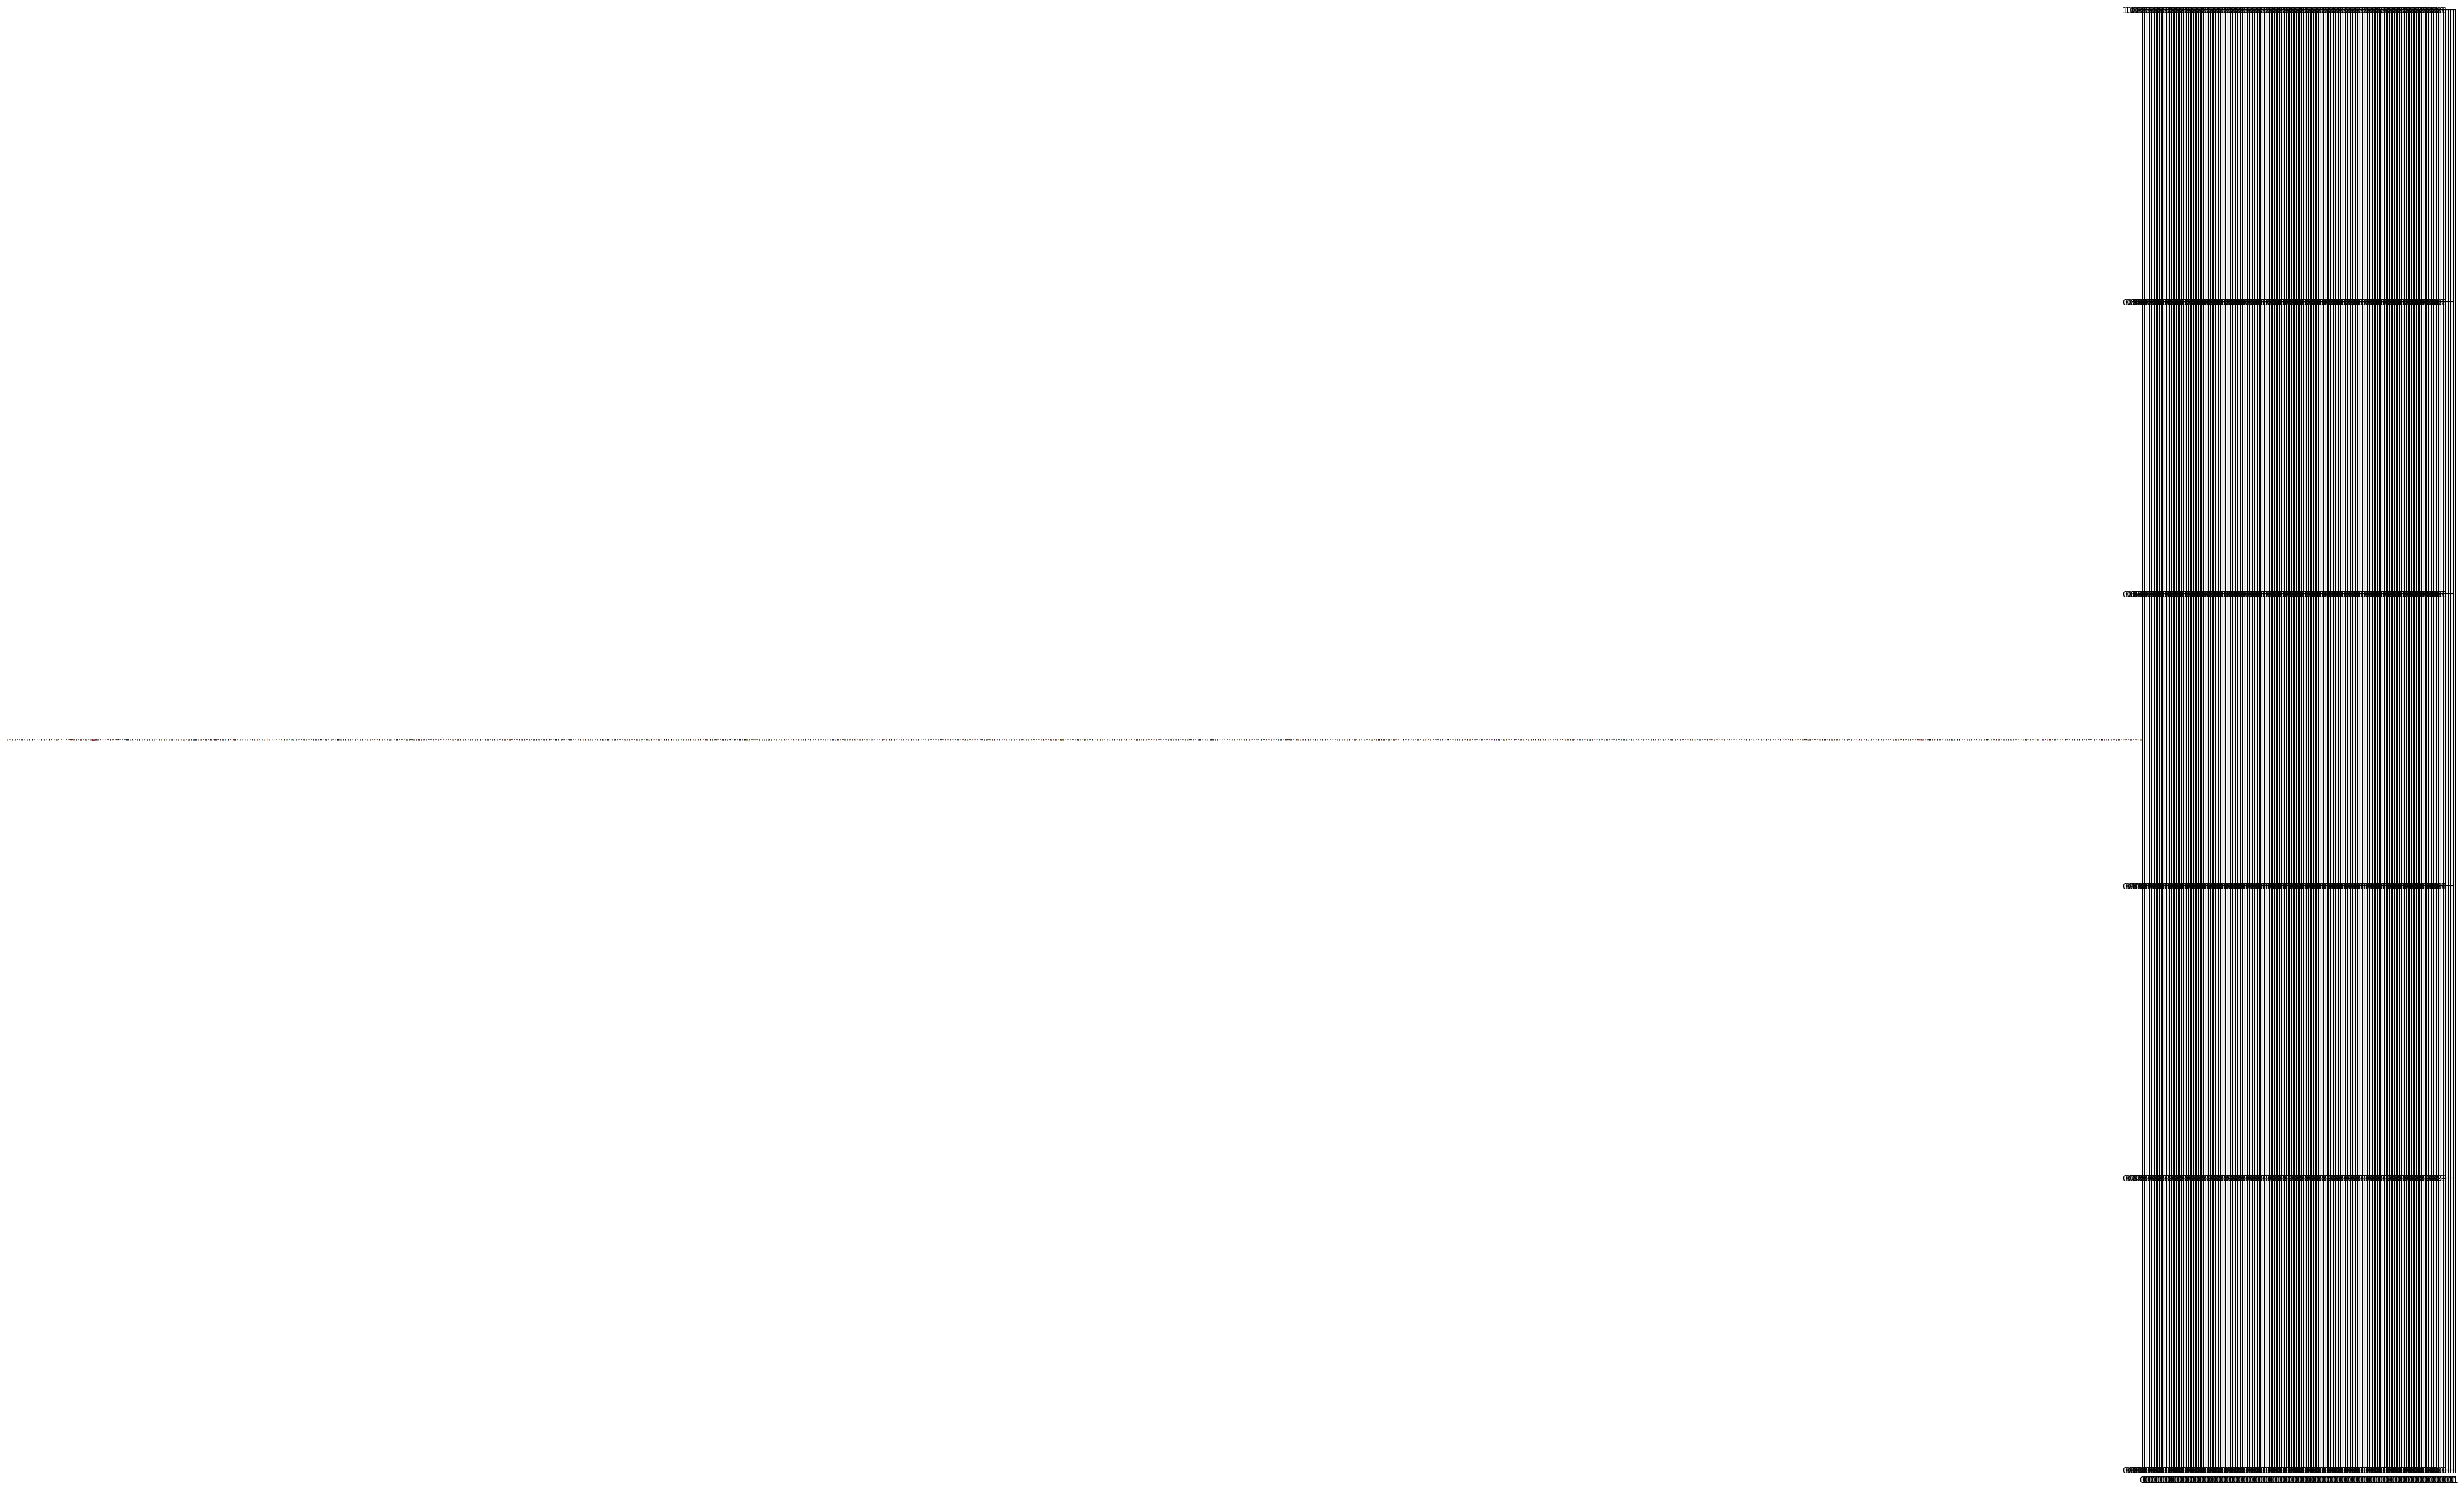

Before cleaning
Top 50 features when designation ['assassin' 'black' 'blood' 'borderlands' 'bundle' 'civilization' 'clancy'
 'collection' 'collector' 'complete' 'dark' 'dawn' 'dead' 'deluxe'
 'digital' 'dlc' 'dragon' 'edition' 'extension' 'farm' 'game' 'ghost'
 'gold' 'haunted' 'ii' 'iii' 'iv' 'jeu' 'legends' 'lego' 'mac' 'mystery'
 'new' 'pack' 'pass' 'quest' 'revolution' 'season' 'sid' 'simulator'
 'star' 'tales' 'tom' 'téléchargement' 'ultimate' 'warhammer' 'wars'
 'world' 'wwe' 'édition']
Top 50 features when description ['10' '39' '64' 'amd' 'bit' 'caractéristiques' 'carte' 'compatible'
 'compte' 'configuration' 'connexion' 'core' 'directx' 'disque' 'dur'
 'espace' 'geforce' 'ghz' 'graphique' 'gtx' 'hd' 'intel' 'internet' 'jeu'
 'joueurs' 'minimale' 'mo' 'mode' 'monde' 'mémoire' 'note' 'nouveaux'
 'nvidia' 'os' 'processeur' 'processor' 'propos' 'radeon' 'ram'
 'recommandée' 'requise' 'space' 'steam' 'système' 'trademarks' 'utiliser'
 'version' 'vidéo' 'windows' 'xp']
Top 50 featur

['clancy',
 'simulator',
 'iron',
 'tales',
 'dlc',
 'wars',
 'iv',
 'haunted',
 'star',
 'complete',
 'mystery',
 'collector',
 'téléchargement',
 'sid',
 'legends',
 'borderlands',
 'blood',
 'season',
 'iii',
 'bundle',
 'gold',
 'black',
 'wwe',
 'assassin',
 'new',
 'deluxe',
 'ii',
 'dragon',
 'tom',
 'world',
 'warhammer',
 'heroes',
 'edition',
 'farm',
 'extension',
 'lego',
 'collection',
 'édition',
 'chronicles',
 'ghost',
 'revolution',
 'dark',
 'pack',
 'digital',
 'pass',
 'quest',
 'cities',
 'ultimate']

words found in 'description' NOT in 'designation': 48


['radeon',
 'os',
 'disque',
 'steam',
 'propos',
 'directx',
 'bit',
 'configuration',
 'version',
 'minimale',
 'utiliser',
 'ghz',
 'minimum',
 'activation',
 'dur',
 'graphique',
 'nouvelles',
 'hd',
 'intel',
 'espace',
 'système',
 'core',
 'recommandée',
 'xp',
 'vidéo',
 'nvidia',
 'windows',
 'gtx',
 'geforce',
 'nouveaux',
 'processeur',
 'compatible',
 'connexion',
 'note',
 'mode',
 'exploitation',
 'mo',
 'joueurs',
 'trademarks',
 'caractéristiques',
 'monde',
 'requise',
 'code',
 'ram',
 'compte',
 'internet',
 'carte',
 'amd']

words found in both 'description' AND 'designation': 2


['jeu', 'mac']

Sammary of differences:


,set_designation,n_designation,set_description,n_description,set_designation_description,n_designation_description,set_intersection,n_set_intersection,set_intersection_1,n_set_intersection_1,set_intersection_2,n_set_intersection_2
0,"['american', 'ans', 'art', 'book', 'books', 'c...",50,"['ammareal', 'ancien', 'anglais', 'année', 'as...",50,"['ammareal', 'ancien', 'année', 'art', 'associ...",50,"['vol', 'revue', 'pays', 'books', 'petit', 'gr...",38,"['salissures', 'usure', 'editeur', 'vendons', ...",38,"['histoire', 'vie', 'collection', 'tome', 'édi...",12
1,"['adaptateur', 'anglais', 'audio', 'best', 'cd...",50,"['audio', 'bouton', 'boutons', 'charge', 'comm...",50,"['adaptateur', 'anglais', 'audio', 'bouton', '...",50,"['simulator', 'complet', 'housse', 'uk', 'jap'...",37,"['produit', 'écran', 'charge', 'haut', 'longue...",37,"['commutateur', 'jeux', 'ps', 'contrôleur', 'p...",13
2,"['accessoires', 'adaptateur', 'autocollants', ...",50,"['batterie', 'bluetooth', 'bouton', 'boutons',...",50,"['batterie', 'bluetooth', 'bouton', 'boutons',...",50,"['station', 'housse', 'joystick', 'autocollant...",25,"['poids', 'produit', 'écran', 'emballage', 'fa...",25,"['chargeur', 'charge', 'ps', 'jeu', 'câble', '...",25
3,"['arcade', 'av', 'bit', 'bits', 'cadeau', 'cam...",50,"['affichage', 'built', 'classic', 'communicati...",50,"['affichage', 'av', 'bit', 'bits', 'built', 'c...",50,"['av', 'mémoire', 'classique', 'charge', 'joue...",38,"['consolepaquet', 'ouicommunication', 'usbtail...",38,"['jeux', 'écran', 'console', 'mini', 'jeu', 'p...",12
4,"['action', 'ball', 'batman', 'black', 'collect...",50,"['accessoires', 'article', 'boite', 'box', 'bo...",50,"['action', 'ball', 'batman', 'black', 'box', '...",50,"['harry', 'set', 'series', 'plomb', 'toys', 's...",36,"['socle', 'boîte', 'emballage', 'peint', 'stre...",36,"['figurine', 'figurines', 'collection', 'shirt...",14
5,"['adrenalyn', 'attax', 'ball', 'bp', 'card', '...",50,"['adversaire', 'atk', 'attaque', 'battle', 'bp...",50,"['adrenalyn', 'attax', 'ball', 'bp', 'card', '...",50,"['set', 'ball', 'commune', 'mint', 'premium', ...",34,"['contrôlez', 'xyz', 'magie', 'recto', 'cimeti...",34,"['reverse', 'oh', 'xy', 'soleil', 'yu', 'pokém...",16
6,"['acrylique', 'ad', 'age', 'air', 'august', 'c...",50,"['accessoires', 'age', 'ans', 'audio', 'batter...",50,"['accessoires', 'ad', 'age', 'august', 'batter...",50,"['dungeons', 'set', 'heroclix', 'air', 'guerri...",38,"['produit', 'écran', 'rythme', 'propos', 'effr...",38,"['figurine', 'halloween', 'danse', 'cosplay', ...",12
7,"['animal', 'animaux', 'baby', 'bleu', 'bois', ...",50,"['ans', 'batterie', 'bois', 'bébé', 'cadeau', ...",50,"['ans', 'batterie', 'bois', 'bébé', 'cadeau', ...",50,"['figurine', 'set', 'rose', 'animaux', 'toys',...",33,"['poids', 'contenu', 'produit', 'télécommande'...",33,"['drone', 'toy', 'pcs', 'rc', 'poupée', 'cadea...",17
8,"['animal', 'animaux', 'board', 'bois', 'boue',...",50,"['animaux', 'ans', 'bois', 'boue', 'bébé', 'ca...",50,"['animaux', 'ans', 'bois', 'boue', 'bébé', 'ca...",50,"['cartoon', 'nuage', 'société', 'board', 'modè...",26,"['produit', 'emballage', 'players', 'cards', '...",26,"['set', 'animaux', 'bois', 'cartes', 'jeu', 's...",24
9,"['accessoires', 'air', 'avion', 'batterie', 'b...",50,"['air', 'arrière', 'batterie', 'caméra', 'cara...",50,"['air', 'altitude', 'arrière', 'avion', 'batte...",50,"['traxxas', 'brushless', 'ch', 'modèle', 'osmo...",27,"['poids', 'produit', 'charge', 'vol', 'emballa...",27,"['drone', 'chargeur', 'télécommande', 'mah', '...",23


all words by code:


,category_code,words,words_count
0,10,"[ammareal, ancien, année, art, associations, a...",50
1,40,"[adaptateur, anglais, audio, bouton, boutons, ...",50
2,50,"[batterie, bluetooth, bouton, boutons, caracté...",50
3,60,"[affichage, av, bit, bits, built, classique, c...",50
4,1140,"[action, ball, batman, black, box, boîte, coll...",50
5,1160,"[adrenalyn, attax, ball, bp, card, carte, cart...",50
6,1180,"[accessoires, ad, age, august, batterie, bluet...",50
7,1280,"[ans, batterie, bois, bébé, cadeau, caractéris...",50
8,1281,"[animaux, ans, bois, boue, bébé, cadeau, capac...",50
9,1300,"[air, altitude, arrière, avion, batterie, camé...",50


-----------------------------------------------------------------------


In [6]:
import re
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
bytypecode = data.groupby('prdtypecode')
nsamples=1000
max_features=50

print("---N of samples for each code:", str(nsamples), "---Max extracted features (words): ", str(max_features) , "---")
print("-----------------------------------------------------------------------------------------------------")

to_ignore = ['cm','mm','taille','dimensions','hauteur','largeur','couleur','nbsp','comprend','description','import','france','japonais','blanc','gris','noir',
                          'le', 'la', 'les', 'un', 'deux', 'trois', 'quatre', 'cinq', 'une', 'et', 'de', 'du', 'des', 'ceci', 'cela', 'plusieurs', 'seul', 'seule', 'avec', 'pour', 
                           'ce', 'ceci', 'cela', 'ceux', 'celles', 'ne', 'non', 'par', 'pour', 'parce', 'que', 'qui', 'comment', 'comme', 'ou', 'où', 'tout', 
                          'toute', 'peut', 'être', 'li', 'ul', 'br', 'b', '<br />', 'x', 'p', 'div', 'h1', 'h2','h3','h4', 'td', 'tr', 'nbsp', 'amp', 
                          'cm', 'm', 'mm', 'm3', 'h', 'l', 'strong', 'ca','ainsi', 'cas', 'g', 'kg', 'gt', 'lt', 'eq', 'neq', 'let', 'neuf', 'quelqu', 
                          'oui', 'non', 'gb', 'mb']

from wordcloud import STOPWORDS
import nltk
from nltk.corpus import stopwords
my_stopwords = set(STOPWORDS).union(to_ignore).union(stopwords.words('french')).union(stopwords.words('english')).union(stopwords.words('german'))

final_stopwords_list = list(fr_stop) + list(en_stop) + list(my_stopwords)


coun_vect1 = CountVectorizer(lowercase=True, stop_words=final_stopwords_list, max_features=max_features)
coun_vect2 = CountVectorizer(lowercase=True, stop_words=final_stopwords_list, max_features=max_features)
# used only for 'description'
coun_vect3 = CountVectorizer(lowercase=True, stop_words=final_stopwords_list, max_features=max_features) 

all_feaures = pd.DataFrame({'category_code': 0, 'words': [], 'words_count': 0 })
summary_df =  pd.DataFrame( { 'set_designation': [],  'n_designation': [],  
                   'set_description': [],  'n_description': [], 
                    'set_designation_description': [], 'n_designation_description': [], 
                    'set_intersection': [], 'n_set_intersection': [],
                      'set_intersection_1': [], 'n_set_intersection_1': [],
                            'set_intersection_2': [], 'n_set_intersection_2': []}
                          )


for code, frame in bytypecode:
    print(f"First {nsamples} entries for type {code!r}")
    fig, axs = plt.subplots(1, nsamples, figsize=(50, 30))
    frame_samples=frame.head(nsamples)
    display(frame_samples[['designation', 'description', 'prdtypecode']])
   
    for ax, (index, row) in zip(axs,frame_samples.iterrows()):
        imgid = row['imageid']
        prdid = row['productid']
        img = mpimg.imread(f'{data_images_root_folder}/image_train/image_{imgid}_product_{prdid}.jpg')
        
        imgplot = ax.imshow(img)
        ax.axis('off')
    plt.show()

    # Text count vectorizer on the product type data frame
    print('Before cleaning')
    count_matrix_desi = coun_vect1.fit_transform(frame['designation'])
    count_matrix_desi_desc = coun_vect2.fit_transform(frame['designation']+frame['description'].fillna(''))
    count_matrix_desc = coun_vect3.fit_transform(frame['description'].fillna(''))
    
    print(f'Top {max_features} features when designation', coun_vect1.get_feature_names_out())
    print(f'Top {max_features} features when description', coun_vect3.get_feature_names_out())
    print(f'Top {max_features} features when designation+description', coun_vect2.get_feature_names_out())
   

    cols =['set_designation', 'n_designation', 
           'set_description', 'n_description', 
           'set_designation_description', 'n_designation_description', 
           'set_intersection', 'n_set_intersection',
          'set_intersection_1', 'n_set_intersection_1']
    print('After cleaning')
    
    frame_cleaned=frame.fillna('')\
        .replace(r'<.*?>','', regex=True)\
          .replace(r'\d+','', regex=True)\
            .replace(r'.*Attention !!! Ce produit est un import.*','', regex=True)\
            .replace(re.compile(r'\[Import Allemand\]'),'', regex=True)\
              #.replace({f'(?i){word}': '' for word in to_ignore}, regex=True)
    count_matrix_desi = coun_vect1.fit_transform(frame_cleaned['designation'])
    count_matrix_desc = coun_vect3.fit_transform(frame_cleaned['description'])
    count_matrix_desi_desc = coun_vect2.fit_transform(frame_cleaned['designation']+frame_cleaned['description'])
    
    set_1 = list(coun_vect1.get_feature_names_out())
    print(f'Top {max_features} features when designation', set_1)
    set_2 = list(coun_vect3.get_feature_names_out())
    print(f'Top {max_features} features when description', set_2)
    set_3 = list(coun_vect2.get_feature_names_out())
    print(f'Top {max_features} features when designation+description', set_3)
   
    # generate np.array for set_3 and write output to csv file (one by code)
    code_words_count = pd.DataFrame(data=count_matrix_desi_desc.toarray(),  columns=coun_vect2.get_feature_names_out())
    # add code column, leter we should add category description
    code_words_count['category_code'] = code
    # write to appropriate csv file
    code_words_count.to_csv('code_' + str(code) +'_words_count.csv')
   
    # add new words list to all_feaures dataframe
    all_feaures.loc[len(all_feaures)] = [code, set_3, len(set_3)]
    
    
    print('======================================================================================================')
    n_designation = len(set_1)
    n_description = len(set_2)
    n_designation_description = len(set_3)
    
    set_intersection = list ( set(set_1) - set(set_2) )
    n_set_intersection = len(set_intersection)
    print("words found in 'designation' NOT in 'description':", n_set_intersection)
    display(set_intersection)
    
    if set_2 != []:
        set_intersection_1 = list ( set(set_2) - set(set_1) )
    else:
        set_intersection_1 = list ( set(set_1) )
    n_set_intersection_1 = len(set_intersection_1)
    print("words found in 'description' NOT in 'designation':", n_set_intersection_1)
    display(set_intersection_1)
    
    set_intersection_2 = list(set(set_1).intersection(set(set_2)))
    n_set_intersection_2 = len(set_intersection_2)
    print("words found in both 'description' AND 'designation':", n_set_intersection_2)
    display(set_intersection_2)
    
    
    # add on row to summary DF summary_df
    summary_df.loc[len(summary_df)] = [str(set_1), str(n_designation), 
                                       str(set_2), str(n_designation),
                                       str(set_3), str(n_designation_description), 
                                       str(set_intersection),str(n_set_intersection),
                                       str(set_intersection_1), str(n_set_intersection_1),
                                      str(set_intersection_2), str(n_set_intersection_2)]    
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print('Sammary of differences:\n=================================') 
    display(summary_df)
    print('all words by code:\n=================================') 
    display(all_feaures)
    all_feaures.to_csv('all_feaures.csv')

print("-----------------------------------------------------------------------")


Combining 'designation' with 'description' seems to give better results in term of identifying the features related to the product type  

Tokens that can be ignored:
* english and french stop words
* cm & mm
* markdown tags
* numerics

From the data assessment above & search made in rakuten website, following product types labels are identified as related to the existing product type codes.

In [16]:
map_prdtypecode_guess={10:'Livres/Livres anciens ?', 
                       40:'Jeux vidéo', 
                       50:'Jeux vidéo/Accessoires', 
                       60:'Consoles', 
                       1140:'Goodies/Figurines', 
                       1160:'Goodies/Cartes de jeux', 
                       1180:'Jouets enfant/occasion ?',
                       1280:'Jouets enfant',
                       1281:'Jouets enfant/occasion ?',
                       1300: 'Modélisme',
                       1301: 'Puériculture',
                       1302: 'Puériculture autre ?',
                       1320: 'Puériculture autre ?',
                       1560: 'Mobilier',
                       1920: 'Coussin Décoratif',
                       1940: 'Alimentation',
                       2060: 'Décoration',
                       2220: 'Aminalerie',
                       2280: 'Revues et magazines anciens',
                       2403: 'Lots de Livres et de Revues',
                       2462: 'Lots de consoles et jeux vidéo',
                       2522: 'Fournitures Papeterie',
                       2582: 'Mobilier de Jardin',
                       2583: 'Entretien piscine & spa',
                       2585: 'Outillage de jardin',
                       2705: 'Livres/Littérature',
                       2905: 'Jeux Vidéo/PC'}
data_prdtypecode_label_guess =pd.DataFrame.from_dict(map_prdtypecode_guess, orient = 'index', columns=['prdtypelabelguess'])

## Text data preprocessing

In [17]:
to_ignore=['cm','mm','taille','dimensions','hauteur','largeur','couleur','nbsp','comprend','description','import','france','japonais','anglais','blanc','gris','noir']
data_cleaned=data\
  .fillna('')\
        .replace(r'<.*?>','', regex=True)\
          .replace(r'\d+','', regex=True)\
            .replace(r'.*Attention !!! Ce produit est un import.*','', regex=True)\
            .replace(re.compile(r'\[Import Allemand\]'),'', regex=True)\
              .replace({f'(?i){word}': '' for word in to_ignore}, regex=True)

data_cleaned["desi_desc"] = data_cleaned["designation"].str.cat(data_cleaned["description"], sep = " ")
data_cleaned.drop(['designation','description'], axis=1, inplace=True)

In [9]:
display(data_cleaned)

,productid,imageid,prdtypecode,desi_desc
0,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / Seiten /...
1,436067568,1008141237,2280,Journal Des Arts (Le) N° Du // - L'art Et Son...
2,201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,50418756,457047496,1280,Peluche Donald - Europe - Disneyland (Marionn...
4,278535884,1077757786,2705,La Guerre Des Tuques Luc a des id&eacute;es de...
...,...,...,...,...
84911,206719094,941495734,40,The Sims [ ]
84912,3065095706,1188462883,2583,Kit piscine acier NEVADA déco pierre Ø .m x .m...
84913,440707564,1009325617,2280,Journal Officiel De La Republique Francaise N°...
84914,3942400296,1267353403,1560,Table Basse Bois De Récupération Massif Base h...


In [18]:
data_cleaned_with_prdtypelabel_guess=pd.merge(left=data_cleaned, left_on='prdtypecode', right=data_prdtypecode_label_guess, right_index=True )
display(data_cleaned_with_prdtypelabel_guess)

,productid,imageid,prdtypecode,desi_desc,prdtypelabelguess
0,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / Seiten /...,Livres/Livres anciens ?
1,436067568,1008141237,2280,Journal Des Arts (Le) N° Du // - L'art Et Son...,Revues et magazines anciens
2,201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,Jeux vidéo/Accessoires
3,50418756,457047496,1280,Peluche Donald - Europe - Disneyland (Marionn...,Jouets enfant
4,278535884,1077757786,2705,La Guerre Des Tuques Luc a des id&eacute;es de...,Livres/Littérature
...,...,...,...,...,...
84911,206719094,941495734,40,The Sims [ ],Jeux vidéo
84912,3065095706,1188462883,2583,Kit piscine acier NEVADA déco pierre Ø .m x .m...,Entretien piscine & spa
84913,440707564,1009325617,2280,Journal Officiel De La Republique Francaise N°...,Revues et magazines anciens
84914,3942400296,1267353403,1560,Table Basse Bois De Récupération Massif Base h...,Mobilier


## Text data exploration

<Axes: >

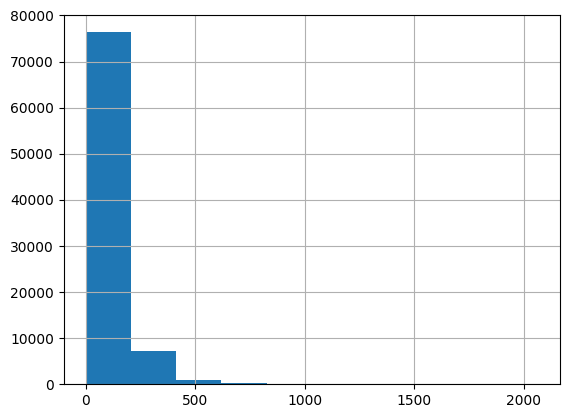

In [19]:
data_cleaned['desi_desc'].str.split().map(lambda x: len(x)).hist()

'designation' range from 10 to 250 characters and generally, it is between 75 to 100 characters

<Axes: >

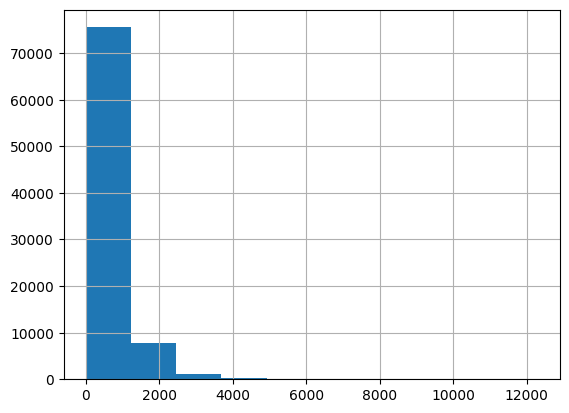

In [20]:
data_cleaned['desi_desc'].str.len().hist()

Number of words in designation ranges from 3 to 50 and mostly falls between 3 to 18 words.

<Axes: >

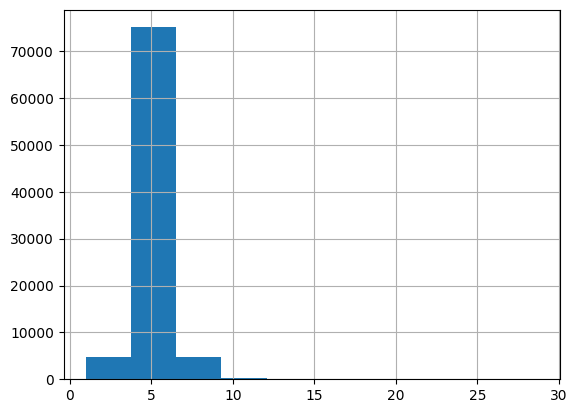

In [13]:
data_cleaned['desi_desc'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

The average word length ranges between 2 to 8 with 5 being the most common length